# Reports

> Generate tearsheets

In [ ]:
#| default_exp reports

In [ ]:
#| export
#| echo: false
import pandas as pd
import numpy as np
from math import sqrt, ceil
from datetime import (
    datetime as dt, timedelta as td
)
from base64 import b64encode
import re as regex
from tabulate import tabulate
import hypersheets
from hypersheets import (
    __version__, stats as _stats,
    utils as _utils, plots as _plots
)
from dateutil.relativedelta import relativedelta

try:
    from IPython.core.display import (
        display as iDisplay, HTML as iHTML
    )
except ImportError:
    pass



In [ ]:
#| hide
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [ ]:
#| export
#| echo: false
# path to location of default report template
std_path = hypersheets.__path__[0]+ '/report.html' 

In [ ]:
#| export
def _get_trading_periods(periods_per_year=252):
    half_year = ceil(periods_per_year/2)
    return periods_per_year, half_year

In [ ]:
#| export
def _match_dates(returns, benchmark):
    returns = returns.loc[
        max(returns.ne(0).idxmax(), benchmark.ne(0).idxmax()):]
    benchmark = benchmark.loc[
        max(returns.ne(0).idxmax(), benchmark.ne(0).idxmax()):]

    return returns, benchmark

In [ ]:
#| export
def _html_table(obj, showindex="default"):
    obj = tabulate(obj, headers="keys", tablefmt='html',
                    floatfmt=".2f", showindex=showindex)
    obj = obj.replace(' style="text-align: right;"', '')
    obj = obj.replace(' style="text-align: left;"', '')
    obj = obj.replace(' style="text-align: center;"', '')
    obj = regex.sub('<td> +', '<td>', obj)
    obj = regex.sub(' +</td>', '</td>', obj)
    obj = regex.sub('<th> +', '<th>', obj)
    obj = regex.sub(' +</th>', '</th>', obj)
    return obj

In [ ]:
#| export
def _download_html(html, filename="quantstats-tearsheet.html"):
    jscode = regex.sub(' +', ' ', """<script>
    var bl=new Blob(['{{html}}'],{type:"text/html"});
    var a=document.createElement("a");
    a.href=URL.createObjectURL(bl);
    a.download="{{filename}}";
    a.hidden=true;document.body.appendChild(a);
    a.innerHTML="download report";
    a.click();</script>""".replace('\n', ''))
    jscode = jscode.replace('{{html}}', regex.sub(
        ' +', ' ', html.replace('\n', '')))
    if _utils._in_notebook():
        iDisplay(iHTML(jscode.replace('{{filename}}', filename)))

In [ ]:
#| export
def _open_html(html):
    jscode = regex.sub(' +', ' ', """<script>
    var win=window.open();win.document.body.innerHTML='{{html}}';
    </script>""".replace('\n', ''))
    jscode = jscode.replace('{{html}}', regex.sub(
        ' +', ' ', html.replace('\n', '')))
    if _utils._in_notebook():
        iDisplay(iHTML(jscode))

In [ ]:
#| export
def _embed_figure(figfile, figfmt):
    figbytes = figfile.getvalue()
    if figfmt == 'svg':
        return figbytes.decode()
    data_uri = b64encode(figbytes).decode()
    return '<img src="data:image/{};base64,{}" />'.format(figfmt, data_uri)


In [ ]:
#| export
def _calc_dd(df, display=True, as_pct=False):
    dd = _stats.to_drawdown_series(df)
    dd_info = _stats.drawdown_details(dd)

    if dd_info.empty:
        return pd.DataFrame()

    if "returns" in dd_info:
        ret_dd = dd_info['returns']
    else:
        ret_dd = dd_info

    dd_stats = {
        'returns': {
            'Max Drawdown %': ret_dd.sort_values(
                by='max drawdown', ascending=True
            )['max drawdown'].values[0] / 100,
            'Longest DD Days': str(np.round(ret_dd.sort_values(
                by='days', ascending=False)['days'].values[0])),
            'Avg. Drawdown %': ret_dd['max drawdown'].mean() / 100,
            'Avg. Drawdown Days': str(np.round(ret_dd['days'].mean()))
        }
    }
    if "benchmark" in df and (dd_info.columns, pd.MultiIndex):
        bench_dd = dd_info['benchmark'].sort_values(by='max drawdown')
        dd_stats['benchmark'] = {
            'Max Drawdown %': bench_dd.sort_values(
                by='max drawdown', ascending=True
            )['max drawdown'].values[0] / 100,
            'Longest DD Days': str(np.round(bench_dd.sort_values(
                by='days', ascending=False)['days'].values[0])),
            'Avg. Drawdown %': bench_dd['max drawdown'].mean() / 100,
            'Avg. Drawdown Days': str(np.round(bench_dd['days'].mean()))
        }

    # pct multiplier
    pct = 100 if display or as_pct else 1

    dd_stats = pd.DataFrame(dd_stats).T
    dd_stats['Max Drawdown %'] = dd_stats['Max Drawdown %'].astype(float) * pct
    dd_stats['Avg. Drawdown %'] = dd_stats['Avg. Drawdown %'].astype(float) * pct

    return dd_stats.T

In [ ]:
#| export
def metrics(returns, benchmark=None, rf=0., display=True,
            mode='basic', sep=False, compounded=True,
            periods_per_year=252, prepare_returns=True,
            match_dates=False, **kwargs):

    win_year, _ = _get_trading_periods(periods_per_year)
#| export#| export
    benchmark_title  = 'Benchmark'
    
    if benchmark is not None:
        if isinstance(benchmark, str):
            benchmark_title  = f'Benchmark ({benchmark.upper()})'
        elif isinstance(benchmark, pd.DataFrame) and len(benchmark.columns) > 1:
            raise ValueError("`benchmark` must be a pandas Series, "
                             "but a multi-column DataFrame was passed")
            
    if kwargs.get('benchmark_title') is not None:
        benchmark_title = kwargs.get('benchmark_title')
    
    
    returns_title = 'Strategy'
    if kwargs.get('returns_title') is not None:
        returns_title = kwargs.get('returns_title')
    
    
    
        
    

    blank = ['']

    if isinstance(returns, pd.DataFrame):
        if len(returns.columns) > 1:
            raise ValueError("`returns` needs to be a Pandas Series or one column DataFrame. multi colums DataFrame was passed")
        returns = returns[returns.columns[0]]

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    df = pd.DataFrame({"returns": returns})

    if benchmark is not None:
        blank = ['', '']
        benchmark = _utils.prepare_benchmark(benchmark, returns.index, rf)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)
        df["returns"] = returns
        df["benchmark"] = benchmark

    df = df.fillna(0)

    # pct multiplier
    pct = 100 if display or "internal" in kwargs else 1
    if kwargs.get("as_pct", False):
        pct = 100

    # return df
    dd = _calc_dd(df, display=(display or "internal" in kwargs),
                  as_pct=kwargs.get("as_pct", False))

    metrics = pd.DataFrame()

    s_start = {'returns': df['returns'].index.strftime('%Y-%m-%d')[0]}
    s_end = {'returns': df['returns'].index.strftime('%Y-%m-%d')[-1]}
    s_rf = {'returns': rf}

    if "benchmark" in df:
        s_start['benchmark'] = df['benchmark'].index.strftime('%Y-%m-%d')[0]
        s_end['benchmark'] = df['benchmark'].index.strftime('%Y-%m-%d')[-1]
        s_rf['benchmark'] = rf

    metrics['Start Period'] = pd.Series(s_start)
    metrics['End Period'] = pd.Series(s_end)
    metrics['Risk-Free Rate %'] = pd.Series(s_rf)*100
    metrics['Time in Market %'] = _stats.exposure(df, prepare_returns=False) * pct

    metrics['~'] = blank

    if compounded:
        metrics['Cumulative Return %'] = (
            _stats.comp(df) * pct).map('{:,.2f}'.format)
    else:
        metrics['Total Return %'] = (df.sum() * pct).map('{:,.2f}'.format)

    metrics['CAGR %'] = _stats.cagr(df, rf, compounded) * pct

    metrics['~~~~~~~~~~~~~~'] = blank

    metrics['Sharpe'] = _stats.sharpe(df, rf, win_year, True)
    metrics['Prob. Sharpe Ratio %'] = _stats.probabilistic_sharpe_ratio(df, rf, win_year, False) * pct
    if mode.lower() == 'full':
        metrics['Smart Sharpe'] = _stats.smart_sharpe(df, rf, win_year, True)
        # metrics['Prob. Smart Sharpe Ratio %'] = _stats.probabilistic_sharpe_ratio(df, rf, win_year, False, True) * pct

    metrics['Sortino'] = _stats.sortino(df, rf, win_year, True)
    if mode.lower() == 'full':
        # metrics['Prob. Sortino Ratio %'] = _stats.probabilistic_sortino_ratio(df, rf, win_year, False) * pct
        metrics['Smart Sortino'] = _stats.smart_sortino(df, rf, win_year, True)
        # metrics['Prob. Smart Sortino Ratio %'] = _stats.probabilistic_sortino_ratio(df, rf, win_year, False, True) * pct

    metrics['Sortino/sqrt2'] = metrics['Sortino'] / sqrt(2)
    if mode.lower() == 'full':
        # metrics['Prob. Sortino/sqrt2 Ratio %'] = _stats.probabilistic_adjusted_sortino_ratio(df, rf, win_year, False) * pct
        metrics['Smart Sortino/sqrt2'] = metrics['Smart Sortino'] / sqrt(2)
        # metrics['Prob. Smart Sortino/ sqrt(2) Ratio %'] = _stats.probabilistic_adjusted_sortino_ratio(df, rf, win_year, False, True) * pct
    metrics['Omega'] = _stats.omega(df, rf, 0., win_year)

    metrics['~~~~~~~~'] = blank
    metrics['Max Drawdown %'] = blank
    metrics['Longest DD Days'] = blank

    if mode.lower() == 'full':
        ret_vol = _stats.volatility(
            df['returns'], win_year, True, prepare_returns=False) * pct
        if "benchmark" in df:
            bench_vol = _stats.volatility(
                df['benchmark'], win_year, True, prepare_returns=False) * pct
            metrics['Volatility (ann.) %'] = [ret_vol, bench_vol]
            metrics['R^2'] = _stats.r_squared(
                df['returns'], df['benchmark'], prepare_returns=False)
            metrics['Information Ratio'] = _stats.information_ratio(
                df['returns'], df['benchmark'], prepare_returns=False)
        else:
            metrics['Volatility (ann.) %'] = [ret_vol]

        metrics['Calmar'] = _stats.calmar(df, prepare_returns=False)
        metrics['Skew'] = _stats.skew(df, prepare_returns=False)
        metrics['Kurtosis'] = _stats.kurtosis(df, prepare_returns=False)

        metrics['~~~~~~~~~~'] = blank

        metrics['Expected Daily %%'] = _stats.expected_return(
            df, prepare_returns=False) * pct
        metrics['Expected Monthly %%'] = _stats.expected_return(
            df, aggregate='M', prepare_returns=False) * pct
        metrics['Expected Yearly %%'] = _stats.expected_return(
            df, aggregate='A', prepare_returns=False) * pct
        metrics['Kelly Criterion %'] = _stats.kelly_criterion(
            df, prepare_returns=False) * pct
        metrics['Risk of Ruin %'] = _stats.risk_of_ruin(
            df, prepare_returns=False)

        metrics['Daily Value-at-Risk %'] = -abs(_stats.var(
            df, prepare_returns=False) * pct)
        metrics['Expected Shortfall (cVaR) %'] = -abs(_stats.cvar(
            df, prepare_returns=False) * pct)

    metrics['~~~~~~'] = blank

    if mode.lower() == 'full':
        metrics['Max Consecutive Wins *int'] = _stats.consecutive_wins(df)
        metrics['Max Consecutive Losses *int'] = _stats.consecutive_losses(df)

    metrics['Gain/Pain Ratio'] = _stats.gain_to_pain_ratio(df, rf)
    metrics['Gain/Pain (1M)'] = _stats.gain_to_pain_ratio(df, rf, "M")
    # if mode.lower() == 'full':
    #     metrics['GPR (3M)'] = _stats.gain_to_pain_ratio(df, rf, "Q")
    #     metrics['GPR (6M)'] = _stats.gain_to_pain_ratio(df, rf, "2Q")
    #     metrics['GPR (1Y)'] = _stats.gain_to_pain_ratio(df, rf, "A")
    metrics['~~~~~~~'] = blank

    metrics['Payoff Ratio'] = _stats.payoff_ratio(df, prepare_returns=False)
    metrics['Profit Factor'] = _stats.profit_factor(df, prepare_returns=False)
    metrics['Common Sense Ratio'] = _stats.common_sense_ratio(df, prepare_returns=False)
    metrics['CPC Index'] = _stats.cpc_index(df, prepare_returns=False)
    metrics['Tail Ratio'] = _stats.tail_ratio(df, prepare_returns=False)
    metrics['Outlier Win Ratio'] = _stats.outlier_win_ratio(df, prepare_returns=False)
    metrics['Outlier Loss Ratio'] = _stats.outlier_loss_ratio(df, prepare_returns=False)

    # returns
    metrics['~~'] = blank
    comp_func = _stats.comp if compounded else np.sum

    today = df.index[-1]  # _dt.today()
    metrics['MTD %'] = comp_func(df[df.index >= dt(today.year, today.month, 1)]) * pct

    d = today - relativedelta(months=3)
    metrics['3M %'] = comp_func(df[df.index >= d]) * pct

    d = today - relativedelta(months=6)
    metrics['6M %'] = comp_func(df[df.index >= d]) * pct

    metrics['YTD %'] = comp_func(df[df.index >= dt(today.year, 1, 1)]) * pct

    d = today - relativedelta(years=1)
    metrics['1Y %'] = comp_func(df[df.index >= d]) * pct

    d = today - relativedelta(months=35)
    metrics['3Y (ann.) %'] = _stats.cagr(df[df.index >= d], 0., compounded) * pct

    d = today - relativedelta(months=59)
    metrics['5Y (ann.) %'] = _stats.cagr(df[df.index >= d], 0., compounded) * pct

    d = today - relativedelta(years=10)
    metrics['10Y (ann.) %'] = _stats.cagr(df[df.index >= d], 0., compounded) * pct

    metrics['All-time (ann.) %'] = _stats.cagr(df, 0., compounded) * pct

    # best/worst
    if mode.lower() == 'full':
        metrics['~~~'] = blank
        metrics['Best Day %'] = _stats.best(df, prepare_returns=False) * pct
        metrics['Worst Day %'] = _stats.worst(df, prepare_returns=False) * pct
        metrics['Best Month %'] = _stats.best(df, aggregate='M', prepare_returns=False) * pct
        metrics['Worst Month %'] = _stats.worst(df, aggregate='M', prepare_returns=False) * pct
        metrics['Best Year %'] = _stats.best(df, aggregate='A', prepare_returns=False) * pct
        metrics['Worst Year %'] = _stats.worst(df, aggregate='A', prepare_returns=False) * pct

    # dd
    metrics['~~~~'] = blank
    for ix, row in dd.iterrows():
        metrics[ix] = row
    metrics['Recovery Factor'] = _stats.recovery_factor(df)
    metrics['Ulcer Index'] = _stats.ulcer_index(df)
    metrics['Serenity Index'] = _stats.serenity_index(df, rf)

    # win rate
    if mode.lower() == 'full':
        metrics['~~~~~'] = blank
        metrics['Avg. Up Month %'] = _stats.avg_win(df, aggregate='M', prepare_returns=False) * pct
        metrics['Avg. Down Month %'] = _stats.avg_loss(df, aggregate='M', prepare_returns=False) * pct
        metrics['Win Days %%'] = _stats.win_rate(df, prepare_returns=False) * pct
        metrics['Win Month %%'] = _stats.win_rate(df, aggregate='M', prepare_returns=False) * pct
        metrics['Win Quarter %%'] = _stats.win_rate(df, aggregate='Q', prepare_returns=False) * pct
        metrics['Win Year %%'] = _stats.win_rate(df, aggregate='A', prepare_returns=False) * pct

        if "benchmark" in df:
            metrics['~~~~~~~~~~~~'] = blank
            greeks = _stats.greeks(df['returns'], df['benchmark'], win_year, prepare_returns=False)
            metrics['Beta'] = [str(round(greeks['beta'], 2)), '-']
            metrics['Alpha'] = [str(round(greeks['alpha'], 2)), '-']
            metrics['Correlation'] = [str(round(df['benchmark'].corr(df['returns']) * pct, 2))+'%', '-']
            metrics['Treynor Ratio'] = [str(round(_stats.treynor_ratio(df['returns'], df['benchmark'], win_year, rf)*pct, 2))+'%', '-']

    # prepare for display
    for col in metrics.columns:
        try:
            metrics[col] = metrics[col].astype(float).round(2)
            if display or "internal" in kwargs:
                metrics[col] = metrics[col].astype(str)
        except Exception:
            pass
        if (display or "internal" in kwargs) and "*int" in col:
            metrics[col] = metrics[col].str.replace('.0', '', regex=False)
            metrics.rename({col: col.replace("*int", "")}, axis=1, inplace=True)
        if (display or "internal" in kwargs) and "%" in col:
            metrics[col] = metrics[col] + '%'
    try:
        metrics['Longest DD Days'] = pd.to_numeric(
            metrics['Longest DD Days']).astype('int')
        metrics['Avg. Drawdown Days'] = pd.to_numeric(
            metrics['Avg. Drawdown Days']).astype('int')

        if display or "internal" in kwargs:
            metrics['Longest DD Days'] = metrics['Longest DD Days'].astype(str)
            metrics['Avg. Drawdown Days'] = metrics['Avg. Drawdown Days'
                                                    ].astype(str)
    except Exception:
        metrics['Longest DD Days'] = '-'
        metrics['Avg. Drawdown Days'] = '-'
        if display or "internal" in kwargs:
            metrics['Longest DD Days'] = '-'
            metrics['Avg. Drawdown Days'] = '-'

    metrics.columns = [
        col if '~' not in col else '' for col in metrics.columns]
    metrics.columns = [
        col[:-1] if '%' in col else col for col in metrics.columns]
    metrics = metrics.T

    if "benchmark" in df:
        metrics.columns = [returns_title, benchmark_title]
    else:
        metrics.columns = [returns_title]

    # cleanups
    metrics.replace([-0, '-0'], 0, inplace=True)
    metrics.replace([np.nan, -np.nan, np.inf, -np.inf,
                     '-nan%', 'nan%', '-nan', 'nan',
                    '-inf%', 'inf%', '-inf', 'inf'], '-', inplace=True)

    if display:
        print(tabulate(metrics, headers="keys", tablefmt='simple'))
        return None

    if not sep:
        metrics = metrics[metrics.index != '']

    # remove spaces from column names
    metrics = metrics.T
    metrics.columns = [c.replace(' %', '').replace(' *int', '').strip() for c in metrics.columns]
    metrics = metrics.T

    return metrics


In [ ]:
#| export
def plots(returns, benchmark=None, grayscale=False,
          figsize=(8, 5), mode='basic', compounded=True,
          periods_per_year=252, prepare_returns=True, match_dates=False):

    win_year, win_half_year = _get_trading_periods(periods_per_year)

    if prepare_returns:
        returns = _utils.prepare_returns(returns)

    if mode.lower() != 'full':
        _plots.snapshot(returns, grayscale=grayscale,
                        figsize=(figsize[0], figsize[0]),
                        show=True, mode=("comp" if compounded else "sum"))

        _plots.monthly_heatmap(returns, grayscale=grayscale,
                               figsize=(figsize[0], figsize[0]*.5),
                               show=True, ylabel=False,
                               compounded=compounded)

        return

    # prepare timeseries
    if benchmark is not None:
        benchmark = _utils.prepare_benchmark(benchmark, returns.index)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)

    _plots.returns(returns, benchmark, grayscale=grayscale,
                   figsize=(figsize[0], figsize[0]*.6),
                   show=True, ylabel=False,
                   prepare_returns=False)

    _plots.log_returns(returns, benchmark, grayscale=grayscale,
                       figsize=(figsize[0], figsize[0]*.5),
                       show=True, ylabel=False,
                       prepare_returns=False)

    if benchmark is not None:
        _plots.returns(returns, benchmark, match_volatility=True,
                       grayscale=grayscale,
                       figsize=(figsize[0], figsize[0]*.5),
                       show=True, ylabel=False,
                       prepare_returns=False)

    _plots.yearly_returns(returns, benchmark,
                          grayscale=grayscale,
                          figsize=(figsize[0], figsize[0]*.5),
                          show=True, ylabel=False,
                          prepare_returns=False)

    _plots.histogram(returns, grayscale=grayscale,
                     figsize=(figsize[0], figsize[0]*.5),
                     show=True, ylabel=False,
                     prepare_returns=False)

    _plots.daily_returns(returns, grayscale=grayscale,
                         figsize=(figsize[0], figsize[0]*.3),
                         show=True, ylabel=False,
                         prepare_returns=False)

    if benchmark is not None:
        _plots.rolling_beta(returns, benchmark, grayscale=grayscale,
                            window1=win_half_year, window2=win_year,
                            figsize=(figsize[0], figsize[0]*.3),
                            show=True, ylabel=False,
                            prepare_returns=False)

    _plots.rolling_volatility(
        returns, benchmark, grayscale=grayscale,
        figsize=(figsize[0], figsize[0]*.3), show=True, ylabel=False,
        period=win_half_year)

    _plots.rolling_sharpe(returns, grayscale=grayscale,
                          figsize=(figsize[0], figsize[0]*.3),
                          show=True, ylabel=False, period=win_half_year)

    _plots.rolling_sortino(returns, grayscale=grayscale,
                           figsize=(figsize[0], figsize[0]*.3),
                           show=True, ylabel=False, period=win_half_year)

    _plots.drawdowns_periods(returns, grayscale=grayscale,
                             figsize=(figsize[0], figsize[0]*.5),
                             show=True, ylabel=False,
                             prepare_returns=False)

    _plots.drawdown(returns, grayscale=grayscale,
                    figsize=(figsize[0], figsize[0]*.4),
                    show=True, ylabel=False)

    _plots.monthly_heatmap(returns, grayscale=grayscale,
                           figsize=(figsize[0], figsize[0]*.5),
                           show=True, ylabel=False)

    _plots.distribution(returns, grayscale=grayscale,
                        figsize=(figsize[0], figsize[0]*.5),
                        show=True, ylabel=False,
                        prepare_returns=False)

In [ ]:
#| export
def html(returns, benchmark=None, rf=0., grayscale=False,
         title='Strategy Tearsheet', output=None, compounded=True,
         periods_per_year=252, download_filename='quantstats-tearsheet.html',
         figfmt='svg', template_path=None, match_dates=False, **kwargs):
    """Production of .html tearsheets"""

    if output is None and not _utils._in_notebook():
        raise ValueError("`file` must be specified")

    win_year, win_half_year = _get_trading_periods(periods_per_year)

    tpl = ""
    with open(template_path or std_path) as f:
        tpl = f.read()
        f.close()
     
    returns_title = 'Strategy'
    # get title for returns: 
    
    if isinstance(returns, str):
        returns_title = returns
    elif isinstance(returns, pd.Series):
        returns_title = returns.name
    elif isinstance(returns, pd.DataFrame):
        returns_title = returns[returns.columns[0]].name
    if kwargs.get('returns_title') is not None:
        returns_title = kwargs.get('returns_title')

    # prepare timeseries
    returns = _utils.prepare_returns(returns)

    if benchmark is not None:
        benchmark_title = kwargs.get('benchmark_title', 'Benchmark')
        if kwargs.get('benchmark_title') is None:
            if isinstance(benchmark, str):
                benchmark_title = benchmark
            elif isinstance(benchmark, pd.Series):
                benchmark_title = benchmark.name
            elif isinstance(benchmark, pd.DataFrame):
                benchmark_title = benchmark[benchmark.columns[0]].name

        tpl = tpl.replace('{{benchmark_title}}', f"Benchmark is {benchmark_title.upper()} | ")
        benchmark = _utils.prepare_benchmark(benchmark, returns.index, rf)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)
    else: benchmark_title = None

    date_range = returns.index.strftime('%e %b, %Y')
    tpl = tpl.replace('{{date_range}}', date_range[0] + ' - ' + date_range[-1])
    tpl = tpl.replace('{{title}}', title)
    tpl = tpl.replace('{{v}}', __version__)

    mtrx = metrics(returns=returns, benchmark=benchmark,
                   rf=rf, display=False, mode='full',
                   sep=True, internal="True",
                   compounded=compounded,
                   periods_per_year=periods_per_year,
                   prepare_returns=False, returns_title = returns_title, benchmark_title=benchmark_title)[2:]

    mtrx.index.name = 'Metric'
    tpl = tpl.replace('{{metrics}}', _html_table(mtrx))
    tpl = tpl.replace('<tr><td></td><td></td><td></td></tr>',
                      '<tr><td colspan="3"><hr></td></tr>')
    tpl = tpl.replace('<tr><td></td><td></td></tr>',
                      '<tr><td colspan="2"><hr></td></tr>')
    
    
    dd = _stats.to_drawdown_series(returns)
    dd_info = _stats.drawdown_details(dd).sort_values(
        by='max drawdown', ascending=True)[:10]

    dd_info = dd_info[['start', 'end', 'max drawdown', 'days']]
    dd_info.columns = ['Started', 'Recovered', 'Drawdown', 'Days']
    tpl = tpl.replace('{{dd_info}}', _html_table(dd_info, False))


    if benchmark is not None:
        yoy = _stats.compare(
            returns, benchmark, aggregate="A", compounded=compounded,
            prepare_returns=False)
        yoy.columns = [returns_title, benchmark_title, 'Multiplier', 'Won']
        yoy.index.name = 'Year'
        tpl = tpl.replace('{{eoy_title}}', '<h3>EOY Returns vs %s Benchmark</h3>' % benchmark_title)
        tpl = tpl.replace('{{eoy_table}}', _html_table(yoy))
    else:
        # pct multiplier
        yoy = pd.DataFrame(
            _utils.group_returns(returns, returns.index.year))
        yoy.columns = ['Return']
        yoy['Cumulative'] = _stats.compsum(yoy['Return'])
        yoy['Return'] = (yoy['Return']* 100).round(2).astype(str)
        yoy['Cumulative'] = (yoy['Cumulative']* 100).round(2).astype(str) + '%'
        yoy.index.name = 'Year'
        tpl = tpl.replace('{{eoy_title}}', '<h3>EOY Returns</h3>')
        tpl = tpl.replace('{{eoy_table}}', _html_table(yoy))
        
        
    if benchmark is not None:
        mom = _stats.compare(
            returns, benchmark, aggregate="M", compounded=compounded,
            prepare_returns=False)
        mom.columns = [returns_title, benchmark_title, 'Multiplier', 'Won']
        mom.index.name = 'Month'
        # mom['Month'] = mom.index
        # mom['Month'] = mom['Month'].apply(lambda x: '-'.join(map(str, x)))
        # mom = mom.reset_index(drop = True)
        # mom = mom.set_index('Month')
        # mom.index.name = 'Month'
        tpl = tpl.replace('{{eom_title}}', '<h3>EOM Returns vs %s Benchmark</h3>' % benchmark_title)
        tpl = tpl.replace('{{eom_table}}', _html_table(mom))
    else:
        # pct multiplier
        mom = pd.DataFrame(
            _utils.group_returns(returns, [returns.index.year, returns.index.month]))
        mom.columns = ['Return']
        mom['Cumulative'] = _stats.compsum(mom['Return'])
        mom['Return'] = (mom['Return']*100).round(2).astype(str)
        mom['Cumulative'] = (mom['Cumulative'] *
                             100).round(2).astype(str) + '%'
        mom.index.name = 'Month'
        # mom['Month'] = mom.index
        # mom['Month'] = mom['Month'].apply(lambda x: '-'.join(map(str, x)))
        # mom = mom.reset_index(drop = True)
        # mom = mom.set_index('Month')
        # mom.index.name = 'Month'
        tpl = tpl.replace('{{eom_title}}', '<h3>EOM Returns</h3>')
        tpl = tpl.replace('{{eom_table}}', _html_table(mom))
        


    # plots
    figfile = _utils.file_stream()
    _plots.returns(returns, benchmark, grayscale=grayscale,
                   figsize=(8, 5), subtitle=False,
                   returns_label=returns_title, benchmark_label=benchmark_title,
                   savefig={'fname': figfile, 'format': figfmt},
                   show=False, ylabel=False, cumulative=compounded,
                   prepare_returns=False)
    tpl = tpl.replace('{{returns}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.log_returns(returns, benchmark, grayscale=grayscale,
                       figsize=(8, 4), subtitle=False,
                       savefig={'fname': figfile, 'format': figfmt},
                       returns_label=returns_title, benchmark_label=benchmark_title,
                       show=False, ylabel=False, cumulative=compounded,
                       prepare_returns=False)
    tpl = tpl.replace('{{log_returns}}', _embed_figure(figfile, figfmt))

    if benchmark is not None:
        figfile = _utils.file_stream()
        _plots.returns(returns, benchmark, match_volatility=True,
                       grayscale=grayscale, figsize=(8, 4), subtitle=False,
                       savefig={'fname': figfile, 'format': figfmt},
                       returns_label=returns_title, benchmark_label=benchmark_title,
                       show=False, ylabel=False, cumulative=compounded,
                       prepare_returns=False)
        tpl = tpl.replace('{{vol_returns}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.yearly_returns(returns, benchmark, grayscale=grayscale,
                          figsize=(8, 4), subtitle=False,
                          savefig={'fname': figfile, 'format': figfmt},
                          returns_label=returns_title, benchmark_label=benchmark_title,
                          show=False, ylabel=False, compounded=compounded,
                          prepare_returns=False)
    tpl = tpl.replace('{{eoy_returns}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.histogram(returns, grayscale=grayscale,
                     figsize=(8, 4), subtitle=False,
                     savefig={'fname': figfile, 'format': figfmt},
                     show=False, ylabel=False, compounded=compounded,
                     prepare_returns=False)
    tpl = tpl.replace('{{monthly_dist}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.daily_returns(returns, grayscale=grayscale,
                         figsize=(8, 3), subtitle=False,
                         savefig={'fname': figfile, 'format': figfmt},
                         show=False, ylabel=False,
                         prepare_returns=False)
    tpl = tpl.replace('{{daily_returns}}', _embed_figure(figfile, figfmt))

    if benchmark is not None:
        figfile = _utils.file_stream()
        _plots.rolling_beta(returns, benchmark, grayscale=grayscale,
                            benchmark_label=benchmark_title,
                            figsize=(8, 3), subtitle=False,
                            window1=win_half_year, window2=win_year,
                            savefig={'fname': figfile, 'format': figfmt},
                            show=False, ylabel=False,
                            prepare_returns=False)
        tpl = tpl.replace('{{rolling_beta}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.rolling_volatility(returns, benchmark, grayscale=grayscale,
                              figsize=(8, 3), subtitle=False,
                              savefig={'fname': figfile, 'format': figfmt},
                              returns_label=returns_title, benchmark_label=benchmark_title,
                              show=False, ylabel=False, period=win_half_year,
                              periods_per_year=win_year)
    tpl = tpl.replace('{{rolling_vol}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.rolling_sharpe(returns, grayscale=grayscale,
                          figsize=(8, 3), subtitle=False,
                          savefig={'fname': figfile, 'format': figfmt},
                          returns_label=returns_title, 
                          show=False, ylabel=False, period=win_half_year,
                          periods_per_year=win_year)
    tpl = tpl.replace('{{rolling_sharpe}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.rolling_sortino(returns, grayscale=grayscale,
                           figsize=(8, 3), subtitle=False,
                           savefig={'fname': figfile, 'format': figfmt},
                           returns_label=returns_title,
                           show=False, ylabel=False, period=win_half_year,
                           periods_per_year=win_year)
    tpl = tpl.replace('{{rolling_sortino}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.drawdowns_periods(returns, grayscale=grayscale,
                             figsize=(8, 4), subtitle=False,
                             savefig={'fname': figfile, 'format': figfmt},
                             show=False, ylabel=False, compounded=compounded,
                             prepare_returns=False)
    tpl = tpl.replace('{{dd_periods}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.drawdown(returns, grayscale=grayscale,
                    figsize=(8, 3), subtitle=False,
                    savefig={'fname': figfile, 'format': figfmt},
                    show=False, ylabel=False)
    tpl = tpl.replace('{{dd_plot}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.monthly_heatmap(returns, grayscale=grayscale,
                           figsize=(8, 4), cbar=False, eoy = True,
                           savefig={'fname': figfile, 'format': figfmt},
                           show=False, ylabel=False, compounded=compounded)
    tpl = tpl.replace('{{monthly_heatmap}}', _embed_figure(figfile, figfmt))
    
    if benchmark is not None:
        figfile = _utils.file_stream()
        _plots.outperformance_heatmap(returns, benchmark=benchmark, grayscale=grayscale,
                               figsize=(8, 4), cbar=False, eoy = True, benchmark_label=benchmark_title,
                               savefig={'fname': figfile, 'format': figfmt},
                               show=False, ylabel=False, compounded=compounded)
        tpl = tpl.replace('{{perf_heatmap}}', _embed_figure(figfile, figfmt))

    figfile = _utils.file_stream()
    _plots.distribution(returns, grayscale=grayscale,
                        figsize=(8, 4), subtitle=False,
                        savefig={'fname': figfile, 'format': figfmt},
                        show=False, ylabel=False, compounded=compounded,
                        prepare_returns=False)
    tpl = tpl.replace('{{returns_dist}}', _embed_figure(figfile, figfmt))

    tpl = regex.sub(r'\{\{(.*?)\}\}', '', tpl)
    tpl = tpl.replace('white-space:pre;', '')

    if output is None:
        # _open_html(tpl)
        _download_html(tpl, download_filename)
        return

    with open(download_filename, 'w', encoding='utf-8') as f:
        f.write(tpl)

In [ ]:
#| hide
returns = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')

html(returns, returns_title = 'SPY', download_filename = 'Example_Tearsheet.html', output= False)

In [ ]:
#| export
def full(returns, benchmark=None, rf=0., grayscale=False,
         figsize=(8, 5), display=True, compounded=True,
         periods_per_year=252, match_dates=False, **kwargs):

    # get titles
    returns_title = 'Strategy'
    # get title for returns: 
    
    if isinstance(returns, str):
        returns_title = returns
    elif isinstance(returns, pd.Series):
        returns_title = returns.name
    elif isinstance(returns, pd.DataFrame):
        returns_title = returns[returns.columns[0]].name
    if kwargs.get('returns_title') is not None:
        returns_title = kwargs.get('returns_title')

    # prepare timeseries
    returns = _utils.prepare_returns(returns)

    if benchmark is not None:
        benchmark_title = kwargs.get('benchmark_title', 'Benchmark')
        if kwargs.get('benchmark_title') is None:
            if isinstance(benchmark, str):
                benchmark_title = benchmark
            elif isinstance(benchmark, pd.Series):
                benchmark_title = benchmark.name
            elif isinstance(benchmark, pd.DataFrame):
                benchmark_title = benchmark[benchmark.columns[0]].name



    # prepare timeseries
    returns = _utils.prepare_returns(returns)
    if benchmark is not None:
        benchmark = _utils.prepare_benchmark(benchmark, returns.index, rf)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)

    dd = _stats.to_drawdown_series(returns)
    col = _stats.drawdown_details(dd).columns[4]
    dd_info = _stats.drawdown_details(dd).sort_values(by = col,
                                                       ascending = True)[:5]

    if not dd_info.empty:
        dd_info.index = range(1, min(6, len(dd_info)+1))
        dd_info.columns = map(lambda x: str(x).title(), dd_info.columns)

    if _utils._in_notebook():
        iDisplay(iHTML('<h4>Performance Metrics</h4>'))
        iDisplay(metrics(returns=returns, benchmark=benchmark,
                         rf=rf, display=display, mode='full',
                         compounded=compounded,
                         periods_per_year=periods_per_year,
                         prepare_returns=False))
        iDisplay(iHTML('<h4>5 Worst Drawdowns</h4>'))
        if dd_info.empty:
            iDisplay(iHTML("<p>(no drawdowns)</p>"))
        else:
            iDisplay(dd_info)

        iDisplay(iHTML('<h4>Strategy Visualization</h4>'))
    else:
        print('[Performance Metrics]\n')
        metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='full',
                compounded=compounded,
                periods_per_year=periods_per_year,
                prepare_returns=False)
        print('\n\n')
        print('[5 Worst Drawdowns]\n')
        if dd_info.empty:
            print("(no drawdowns)")
        else:
            print(tabulate(dd_info, headers="keys",
                            tablefmt='simple', floatfmt=".2f"))
        print('\n\n')
        print('[Strategy Visualization]\nvia Matplotlib')

    plots(returns=returns, benchmark=benchmark,
          grayscale=grayscale, figsize=figsize, mode='full',
          periods_per_year=periods_per_year, prepare_returns=False)

,Strategy,Benchmark
Start Period,2017-10-02,2017-10-02
End Period,2022-09-29,2022-09-29
Risk-Free Rate,0,0
Time in Market,1.0,1.0
Cumulative Return,0.57,0.93
...,...,...
Win Year,0.67,0.67
Beta,0.77,-
Alpha,-0.01,-
Correlation,0.93%,-


,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-23,2020-08-10,172,-33.717271,-29.109765
2,2022-01-04,2022-09-29,2022-09-29,268,-23.177148,-23.009976
3,2018-09-21,2018-12-24,2019-04-12,203,-19.348919,-15.952029
4,2018-01-29,2018-02-08,2018-08-06,189,-10.101887,-9.594698
5,2020-09-03,2020-09-23,2020-11-11,69,-9.440429,-9.199049


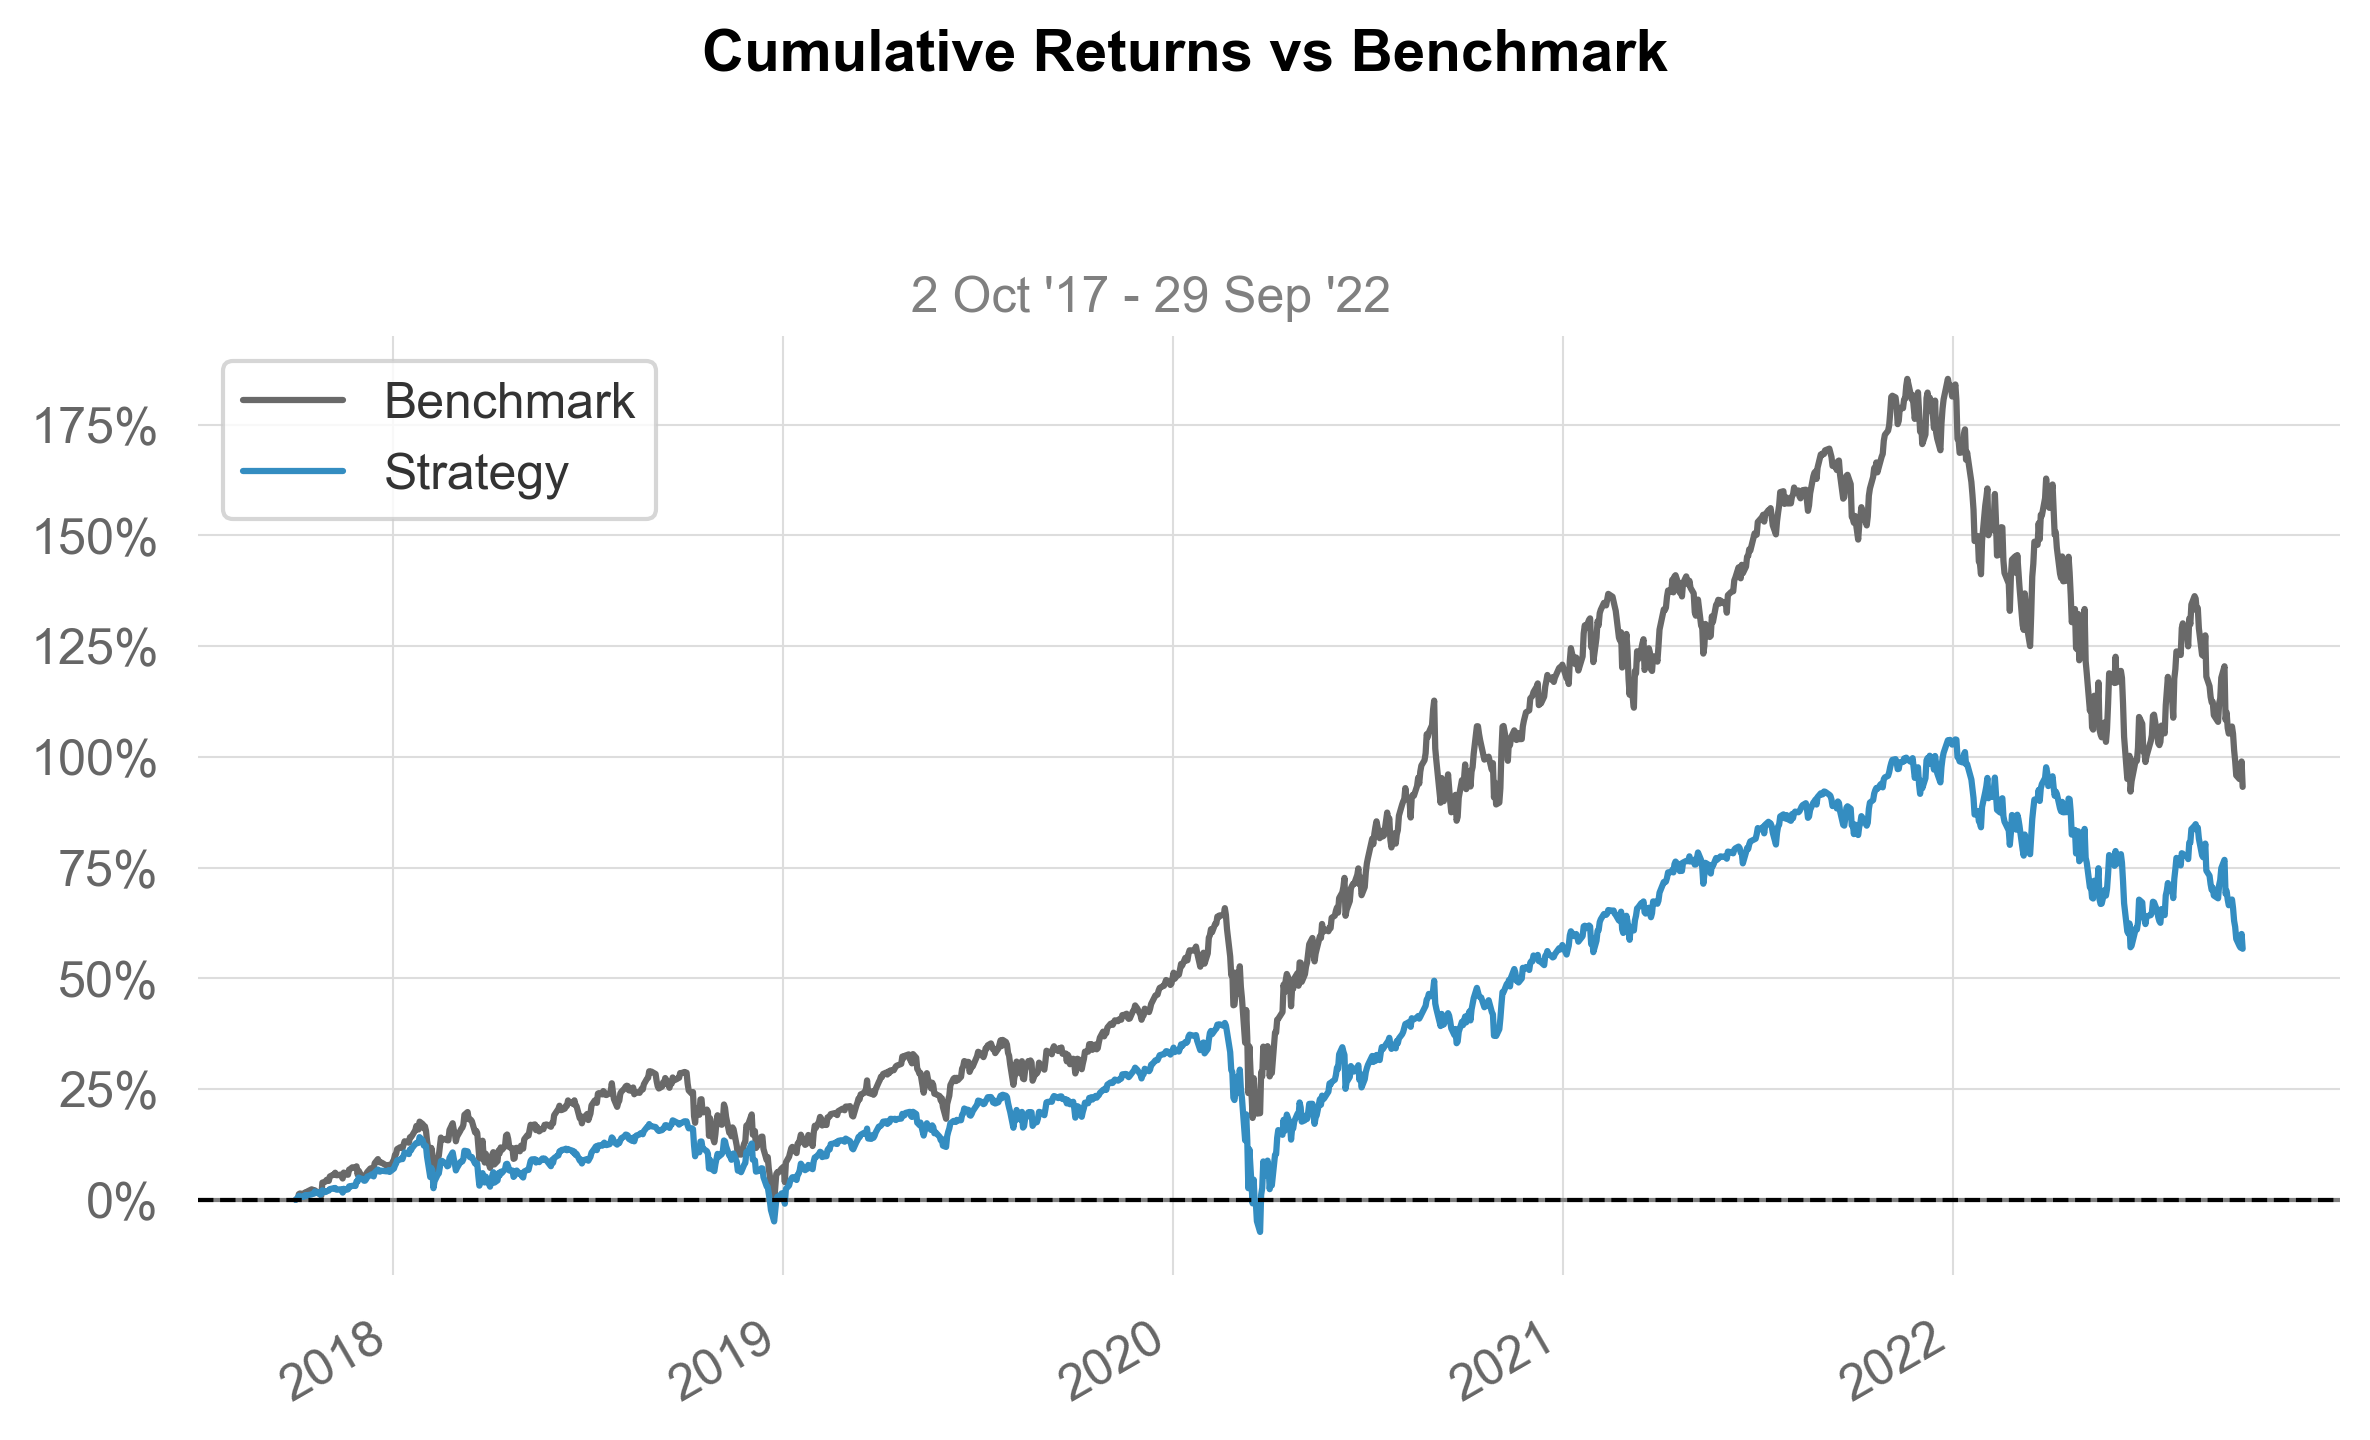

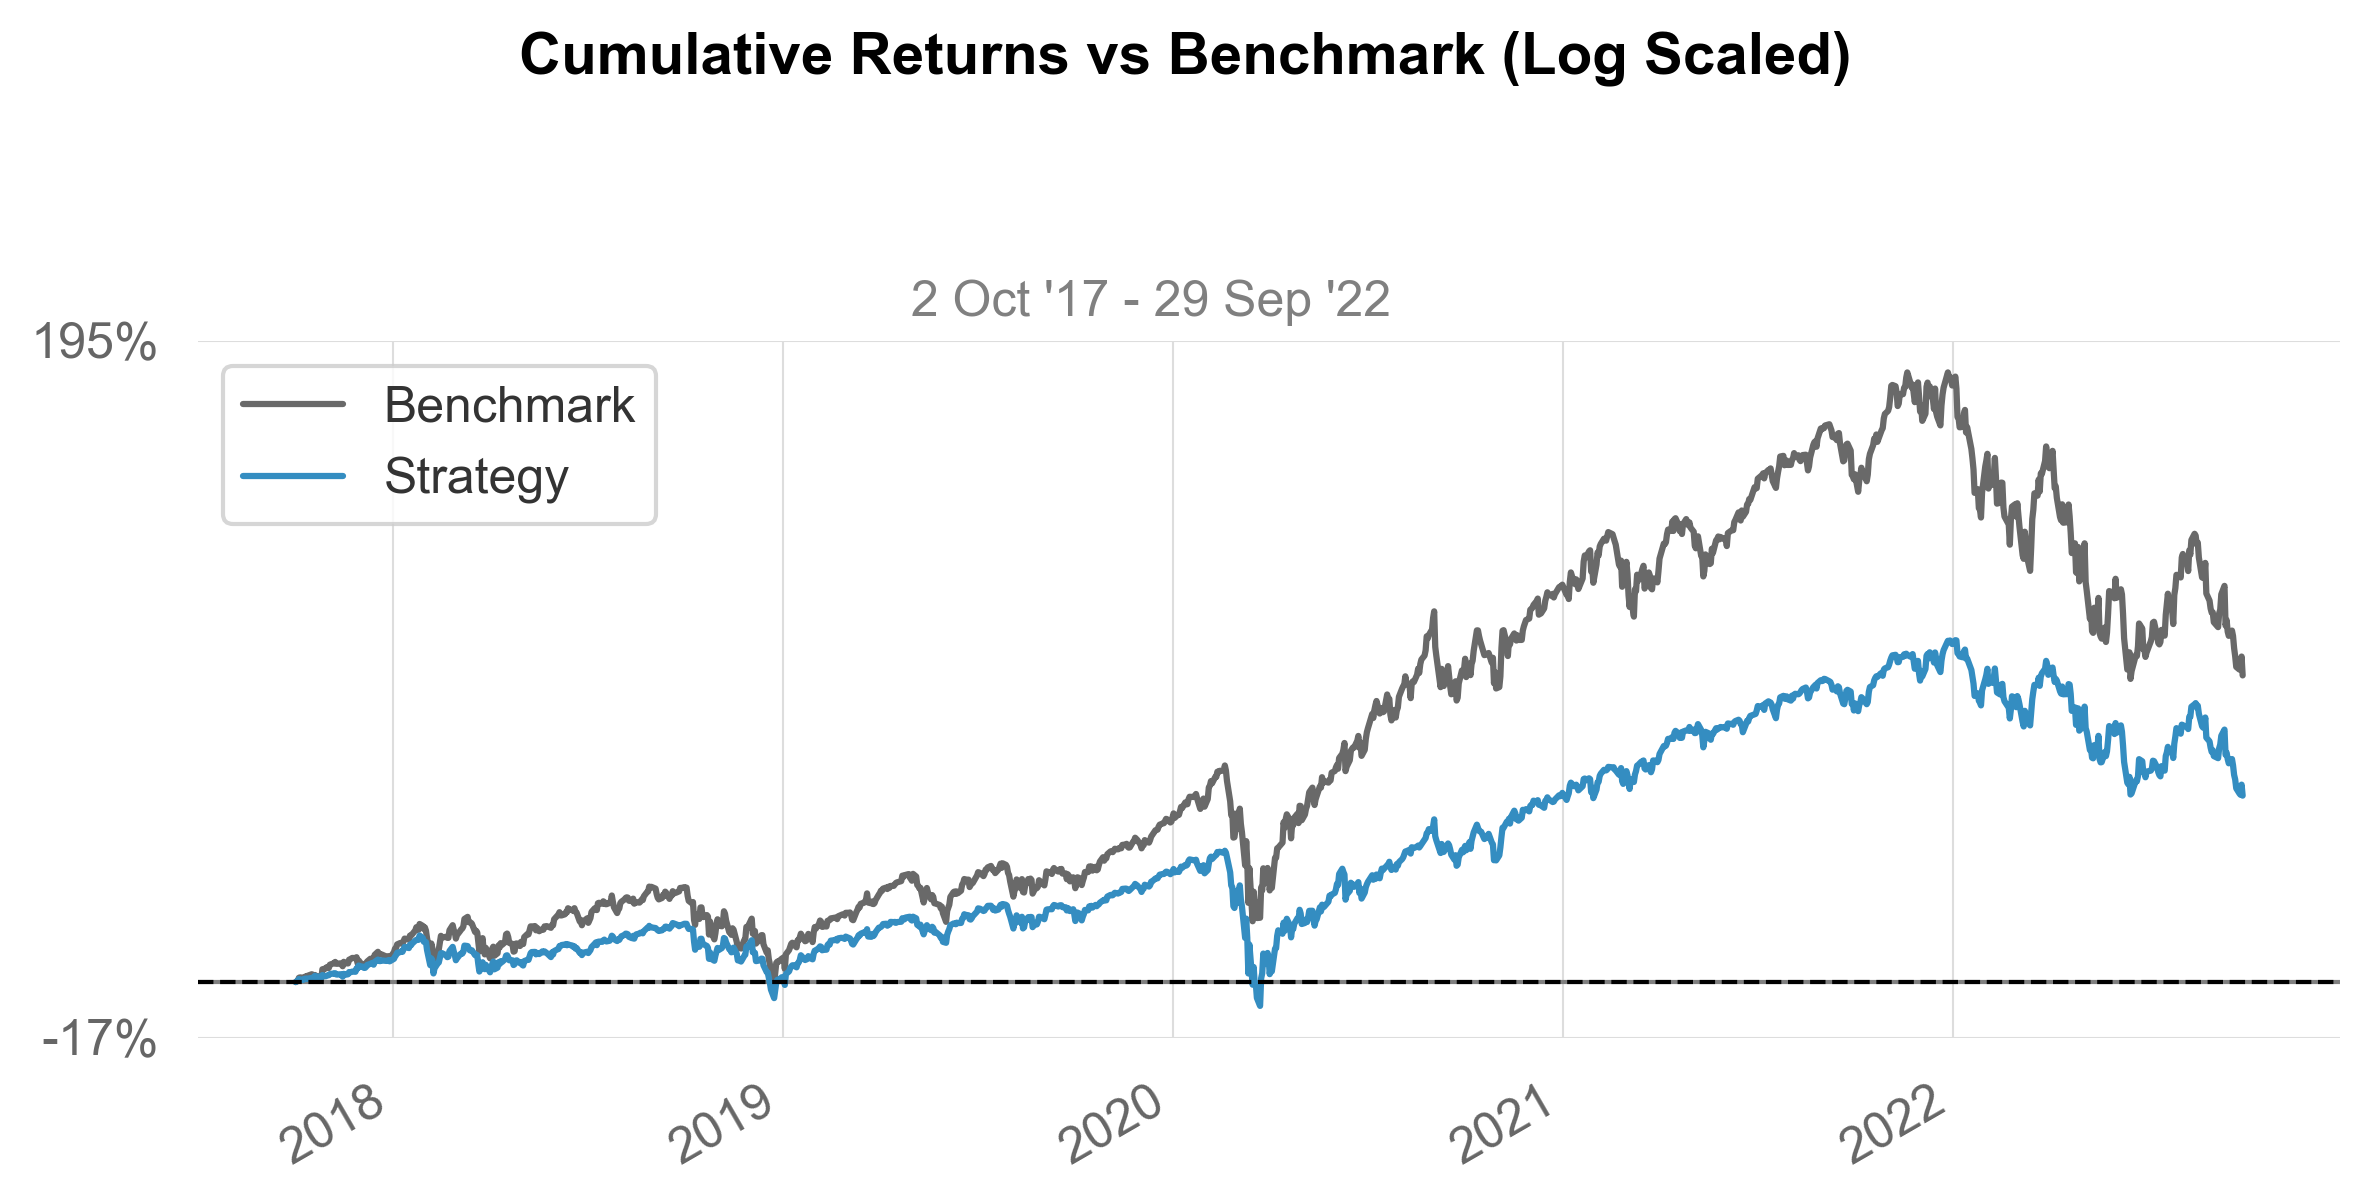

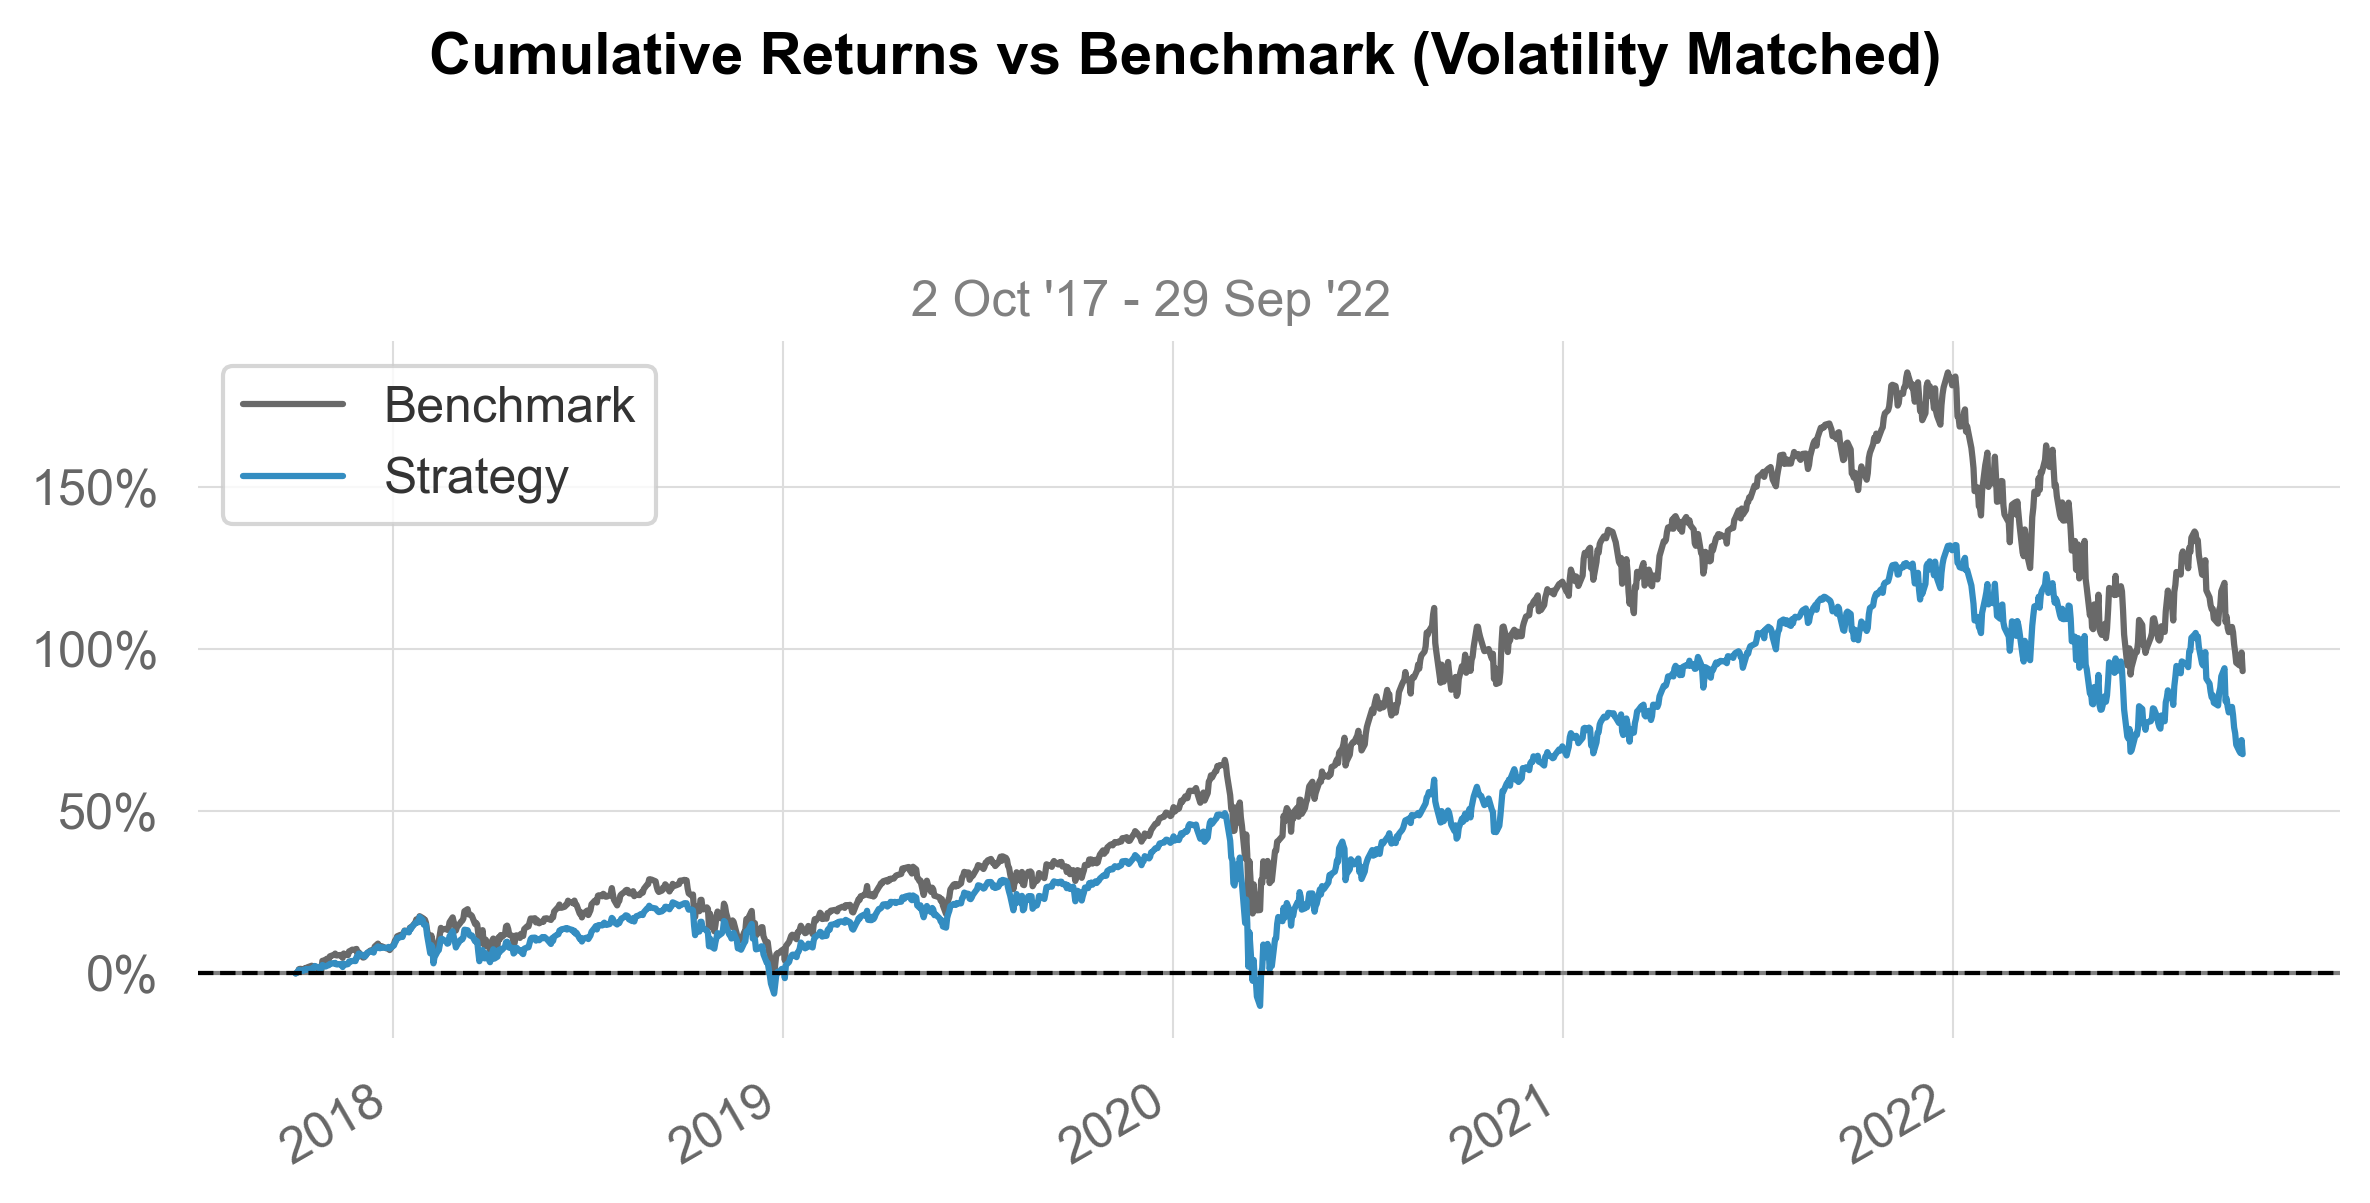

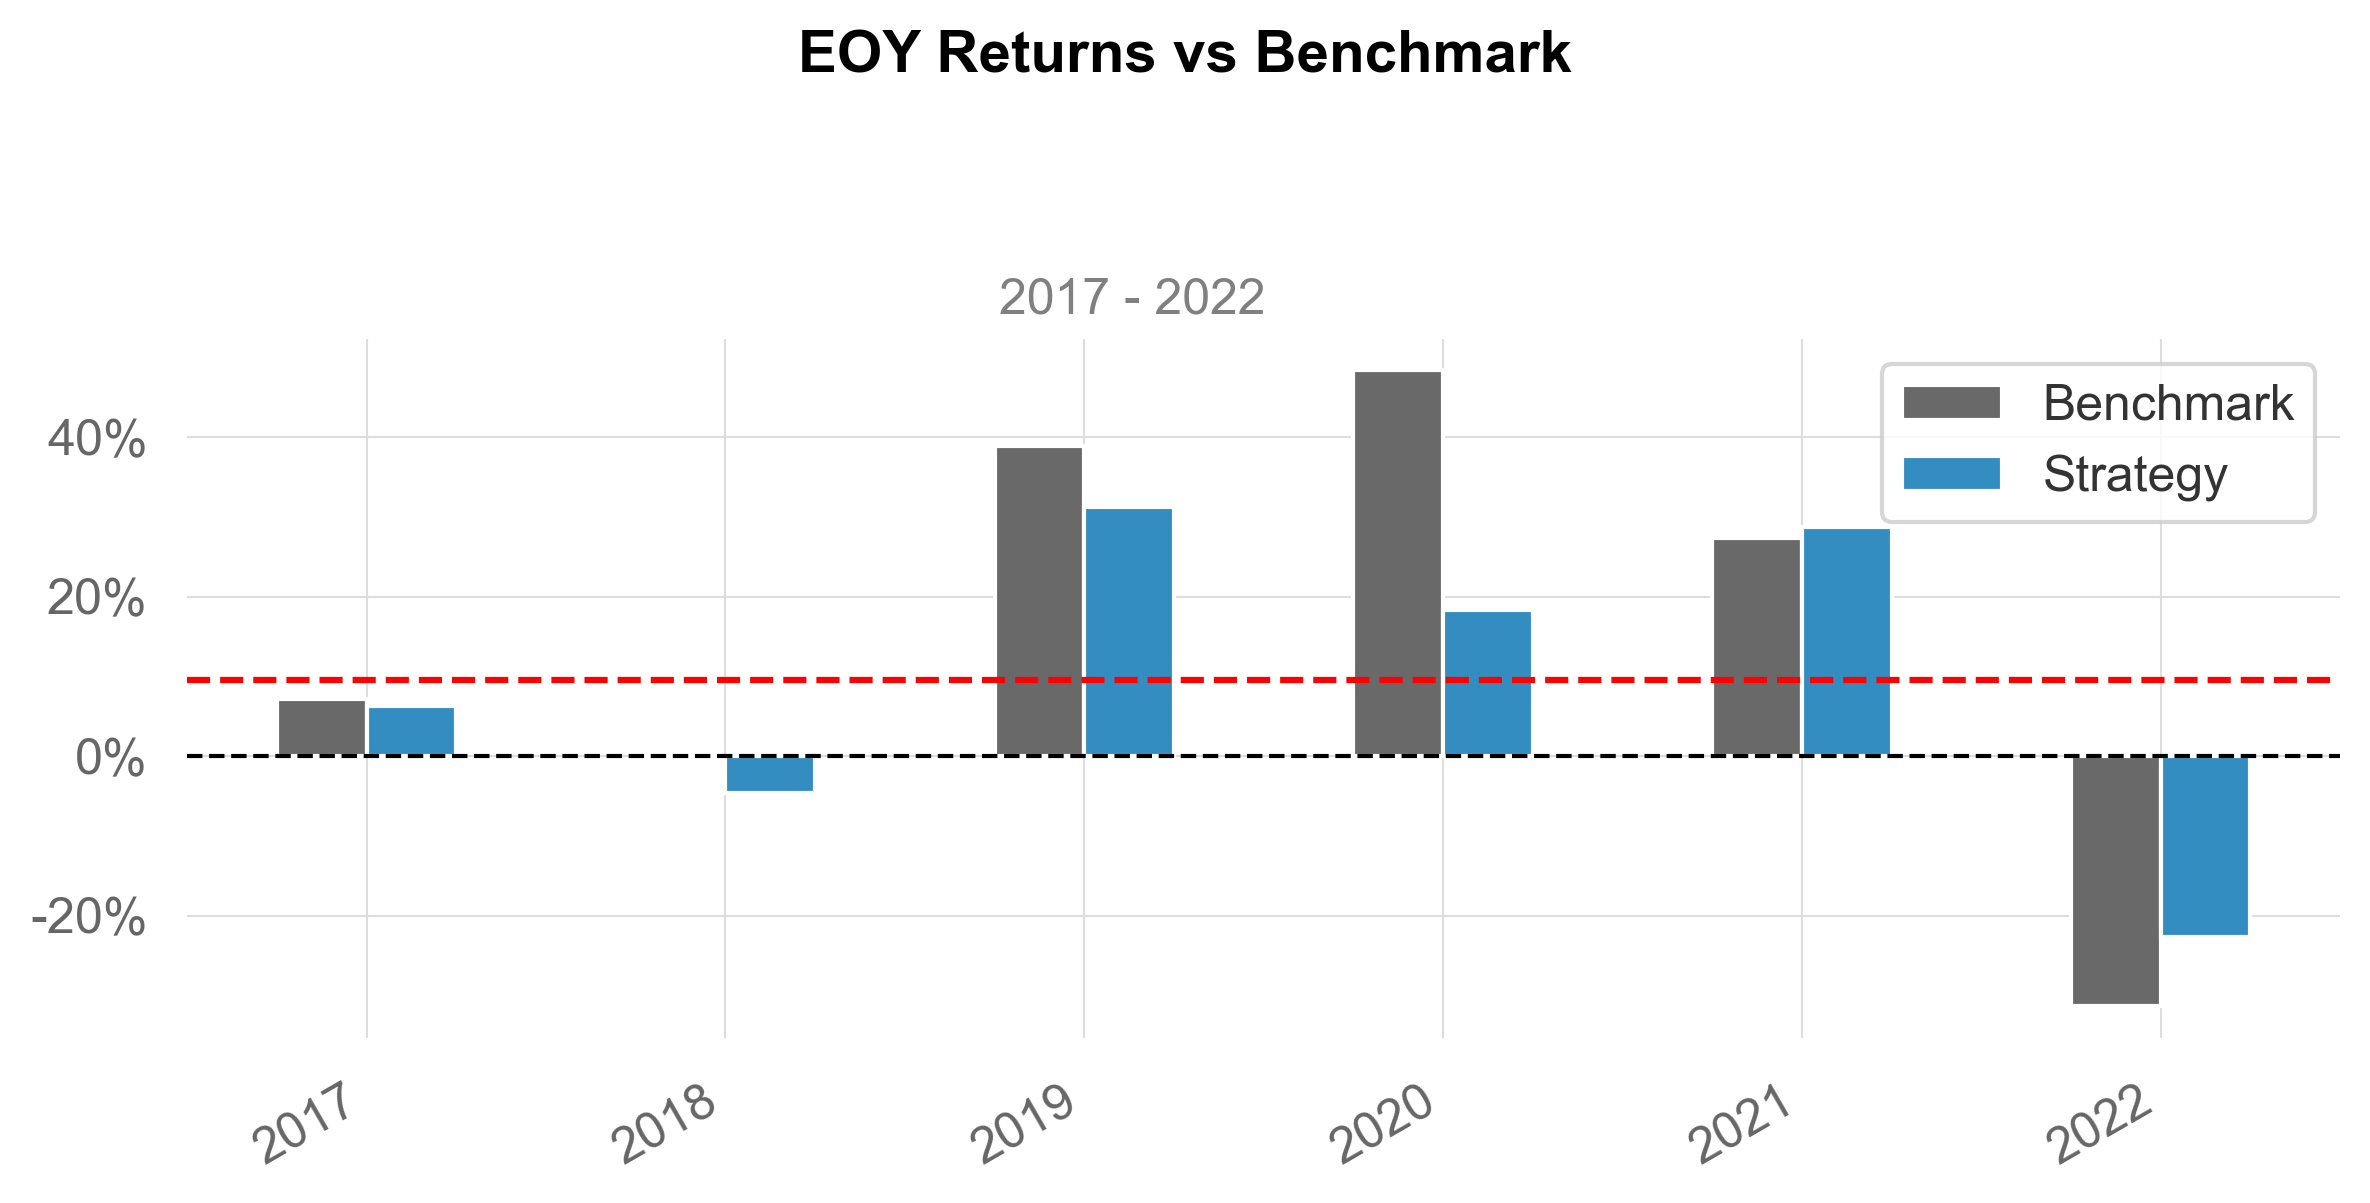

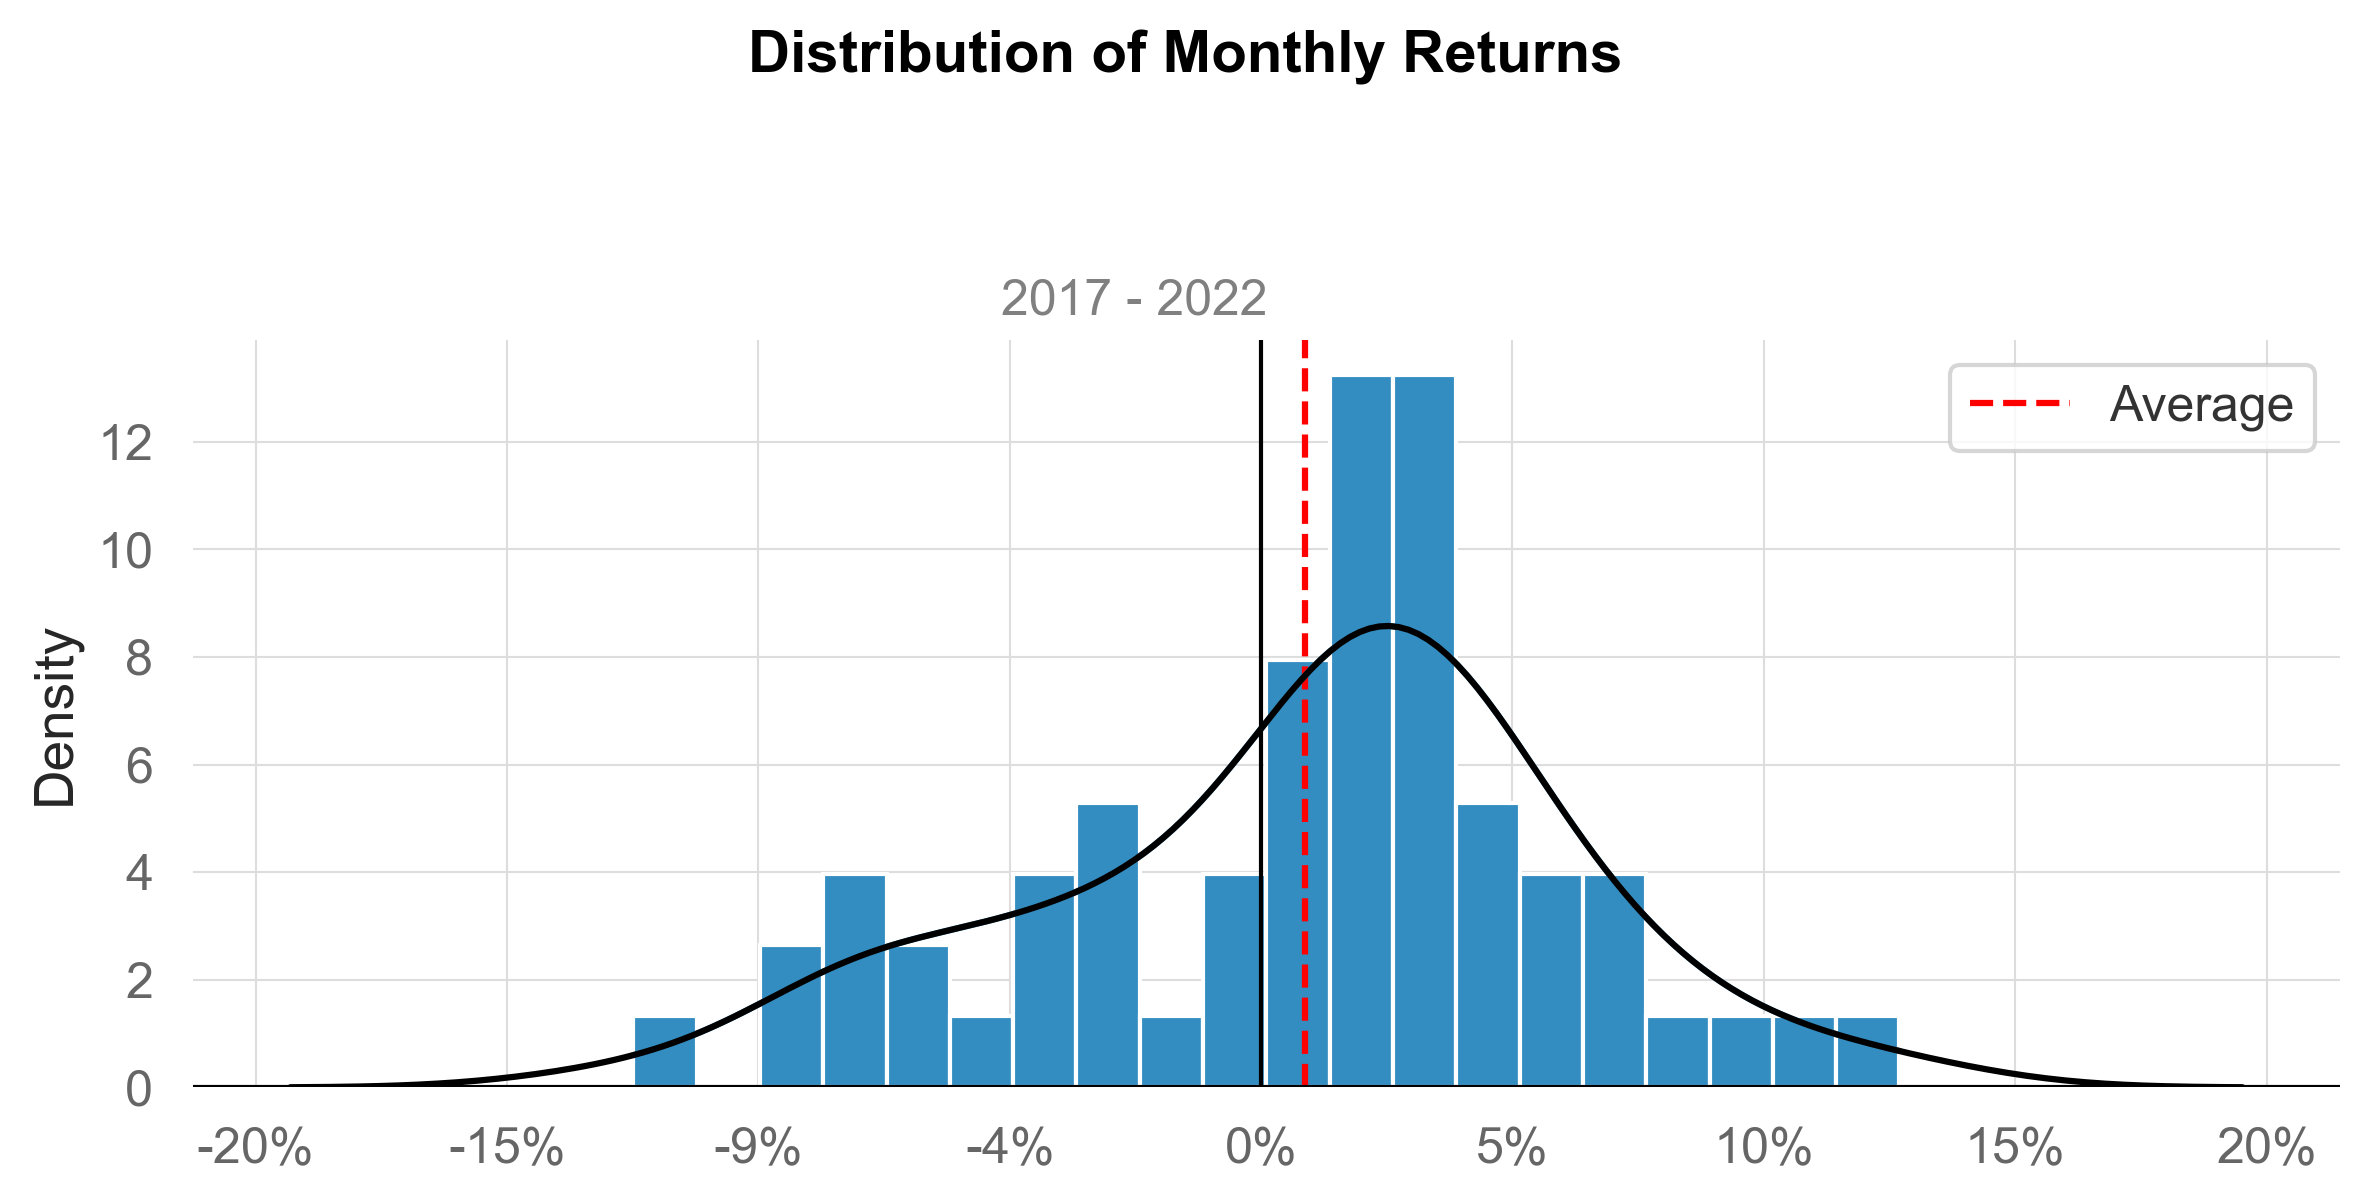

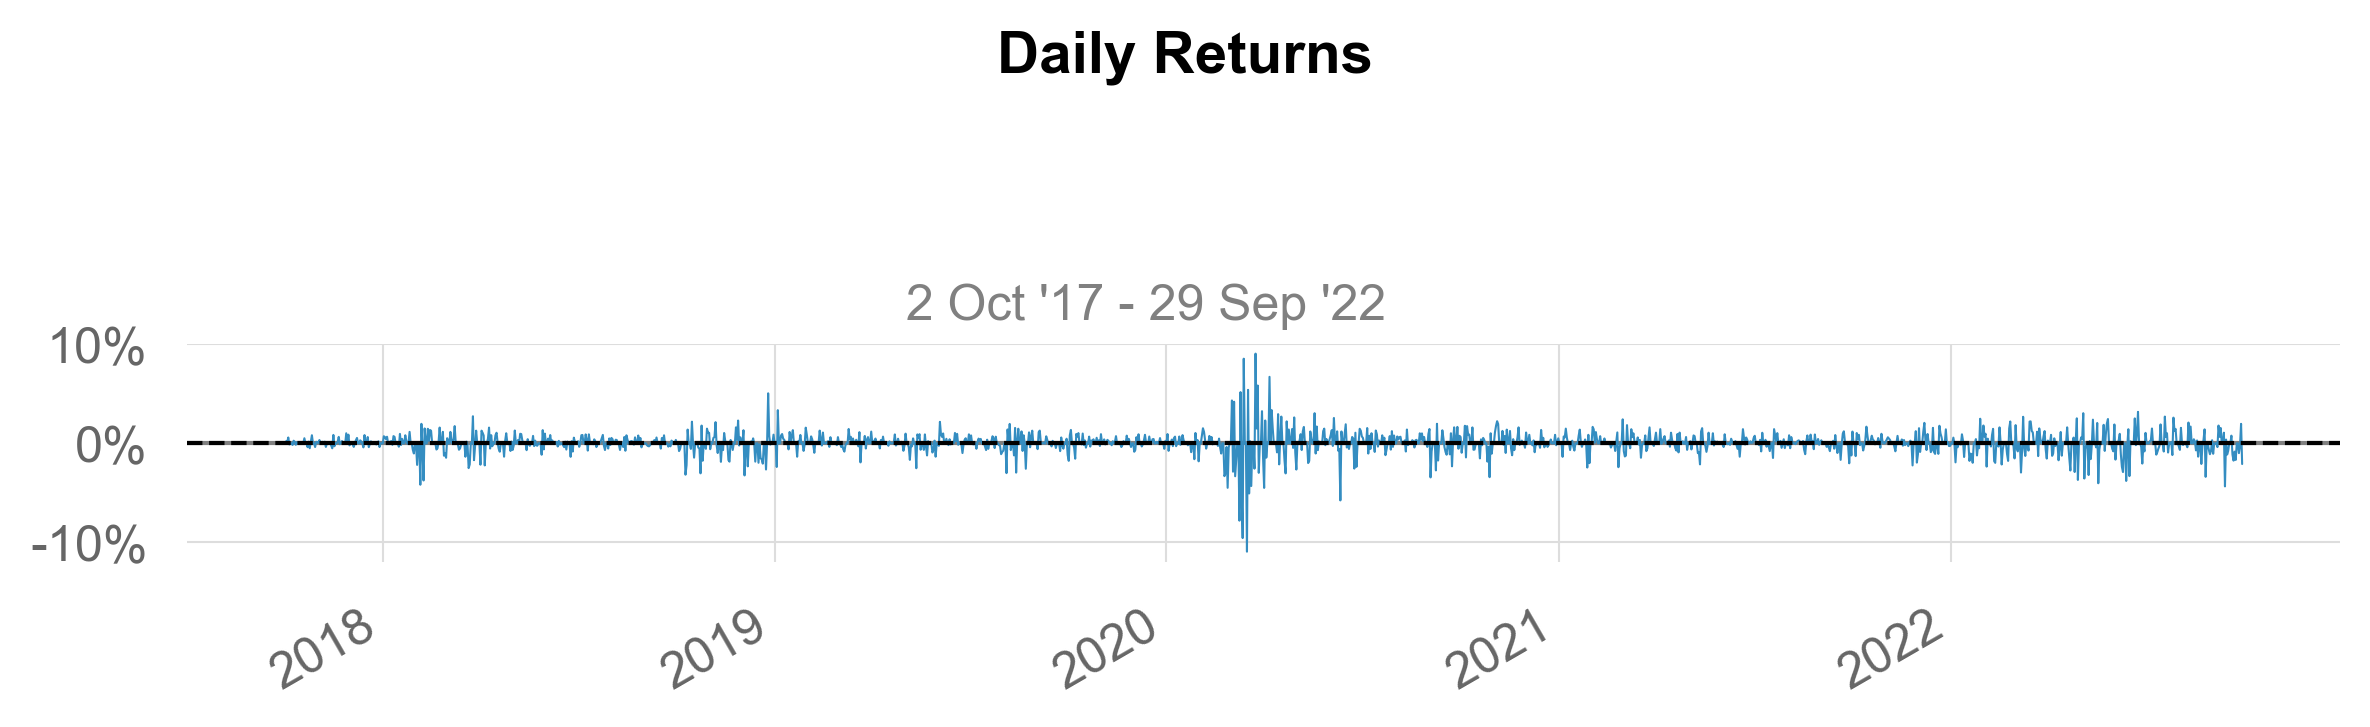

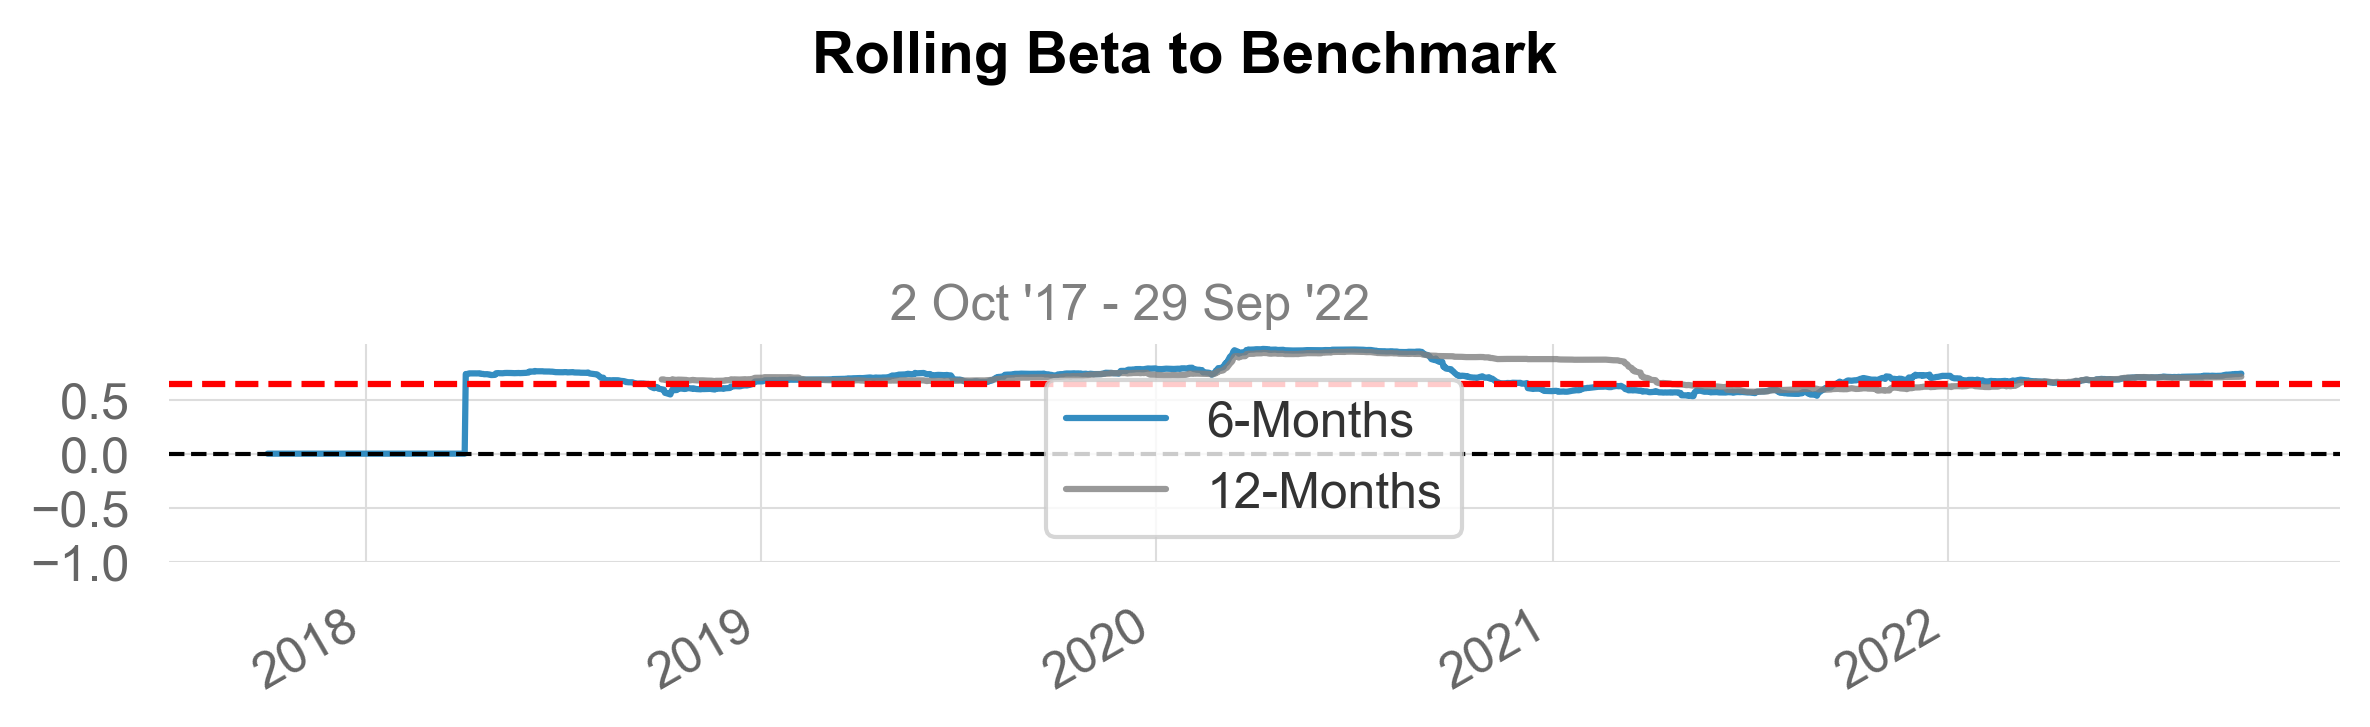

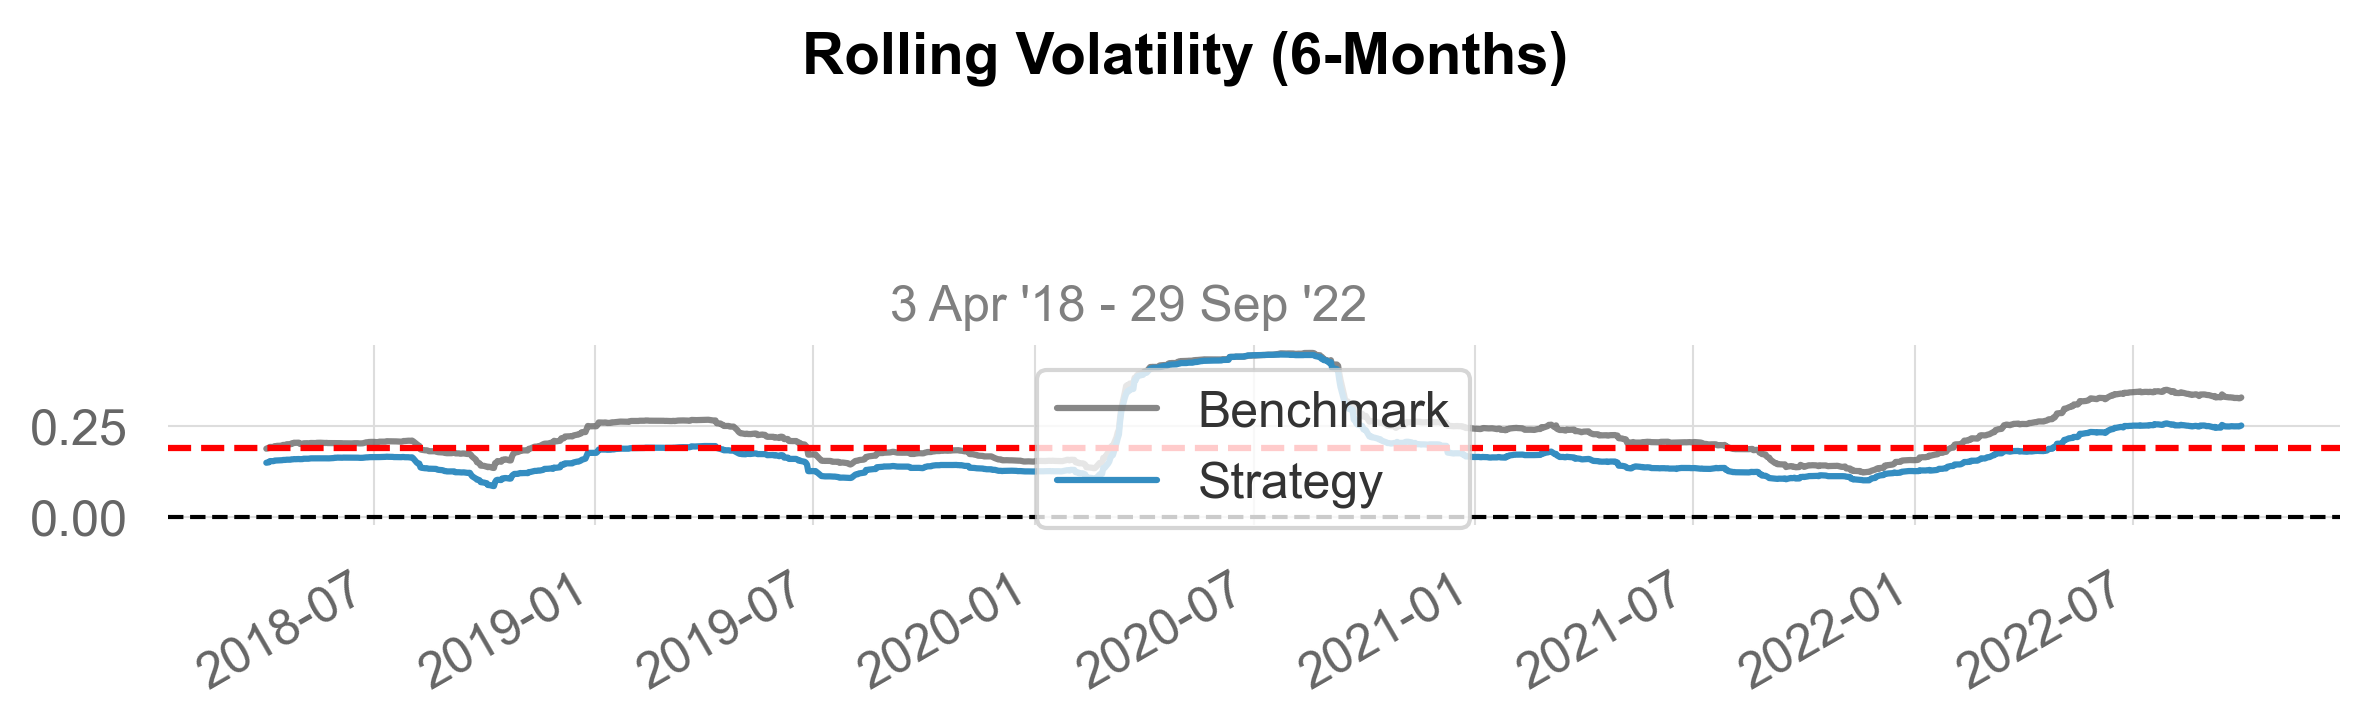

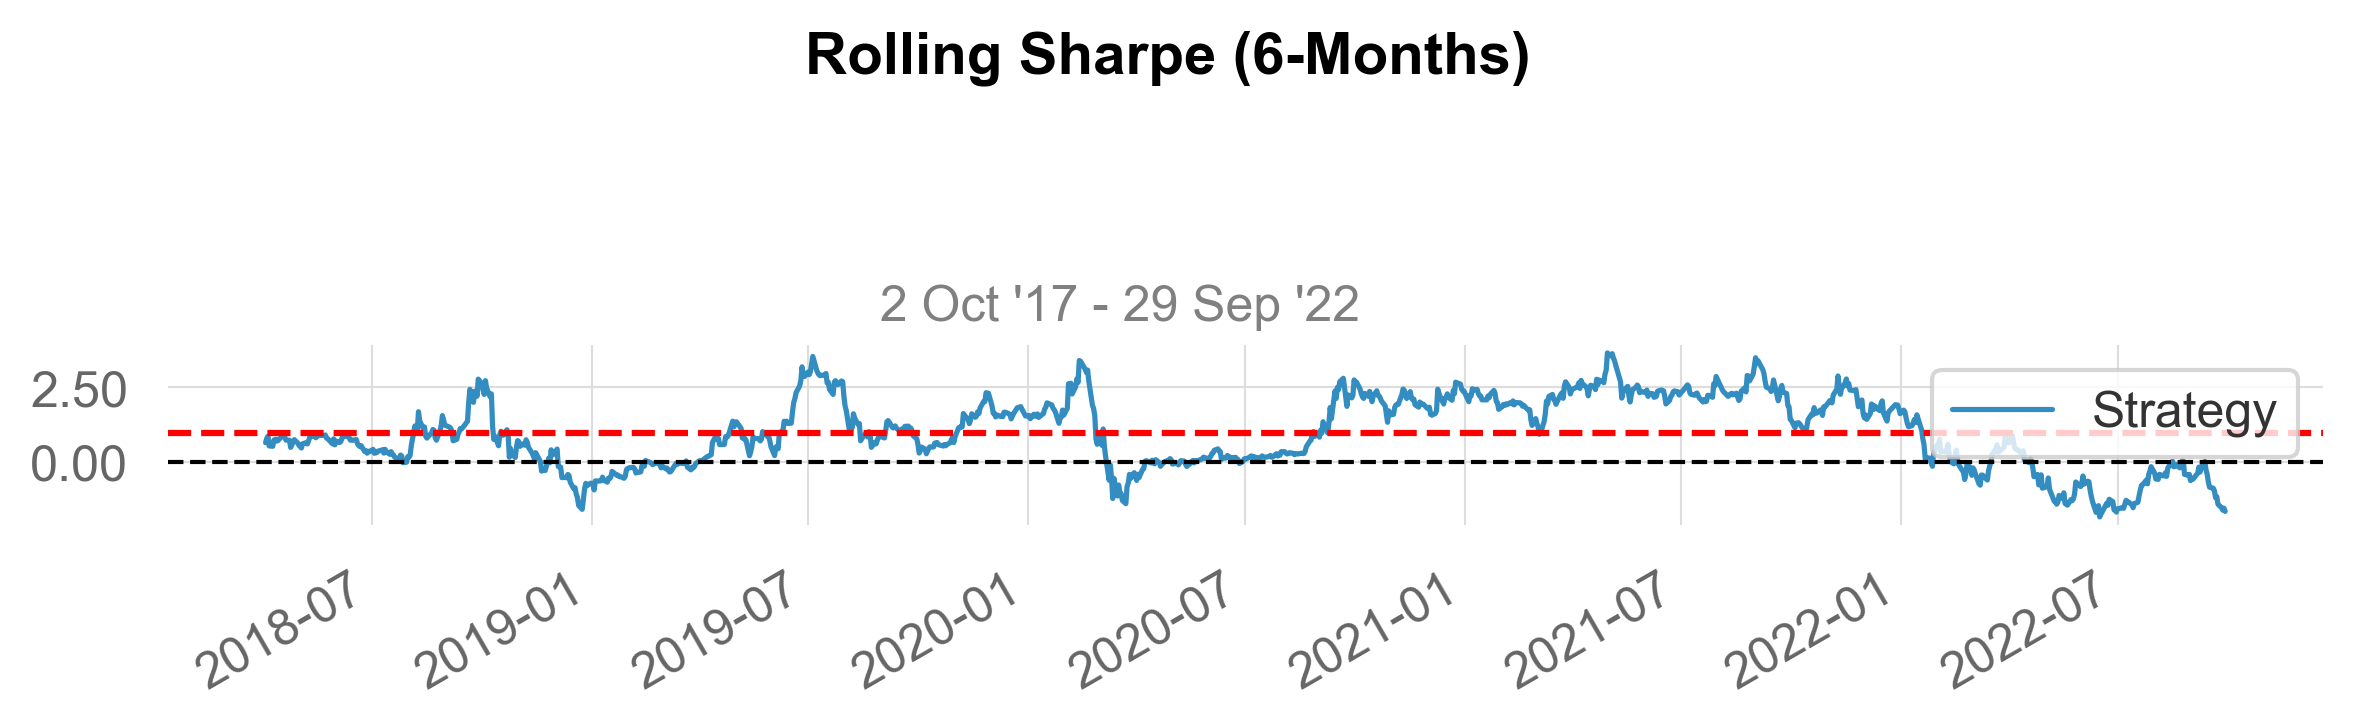

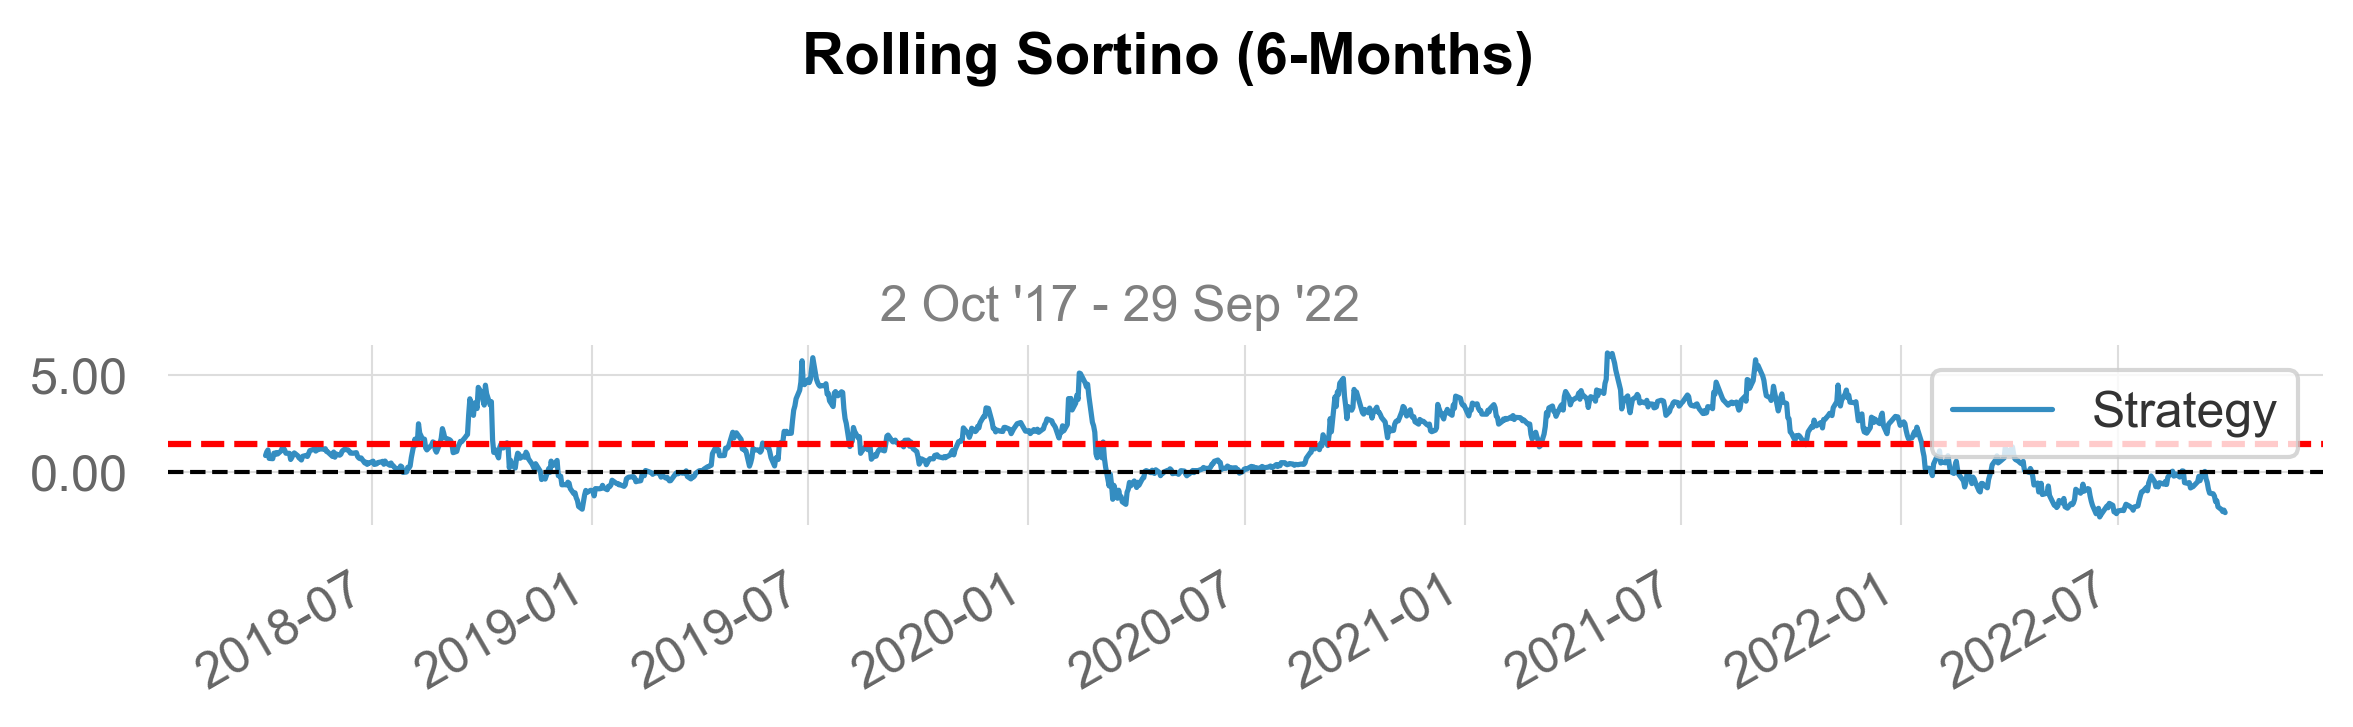

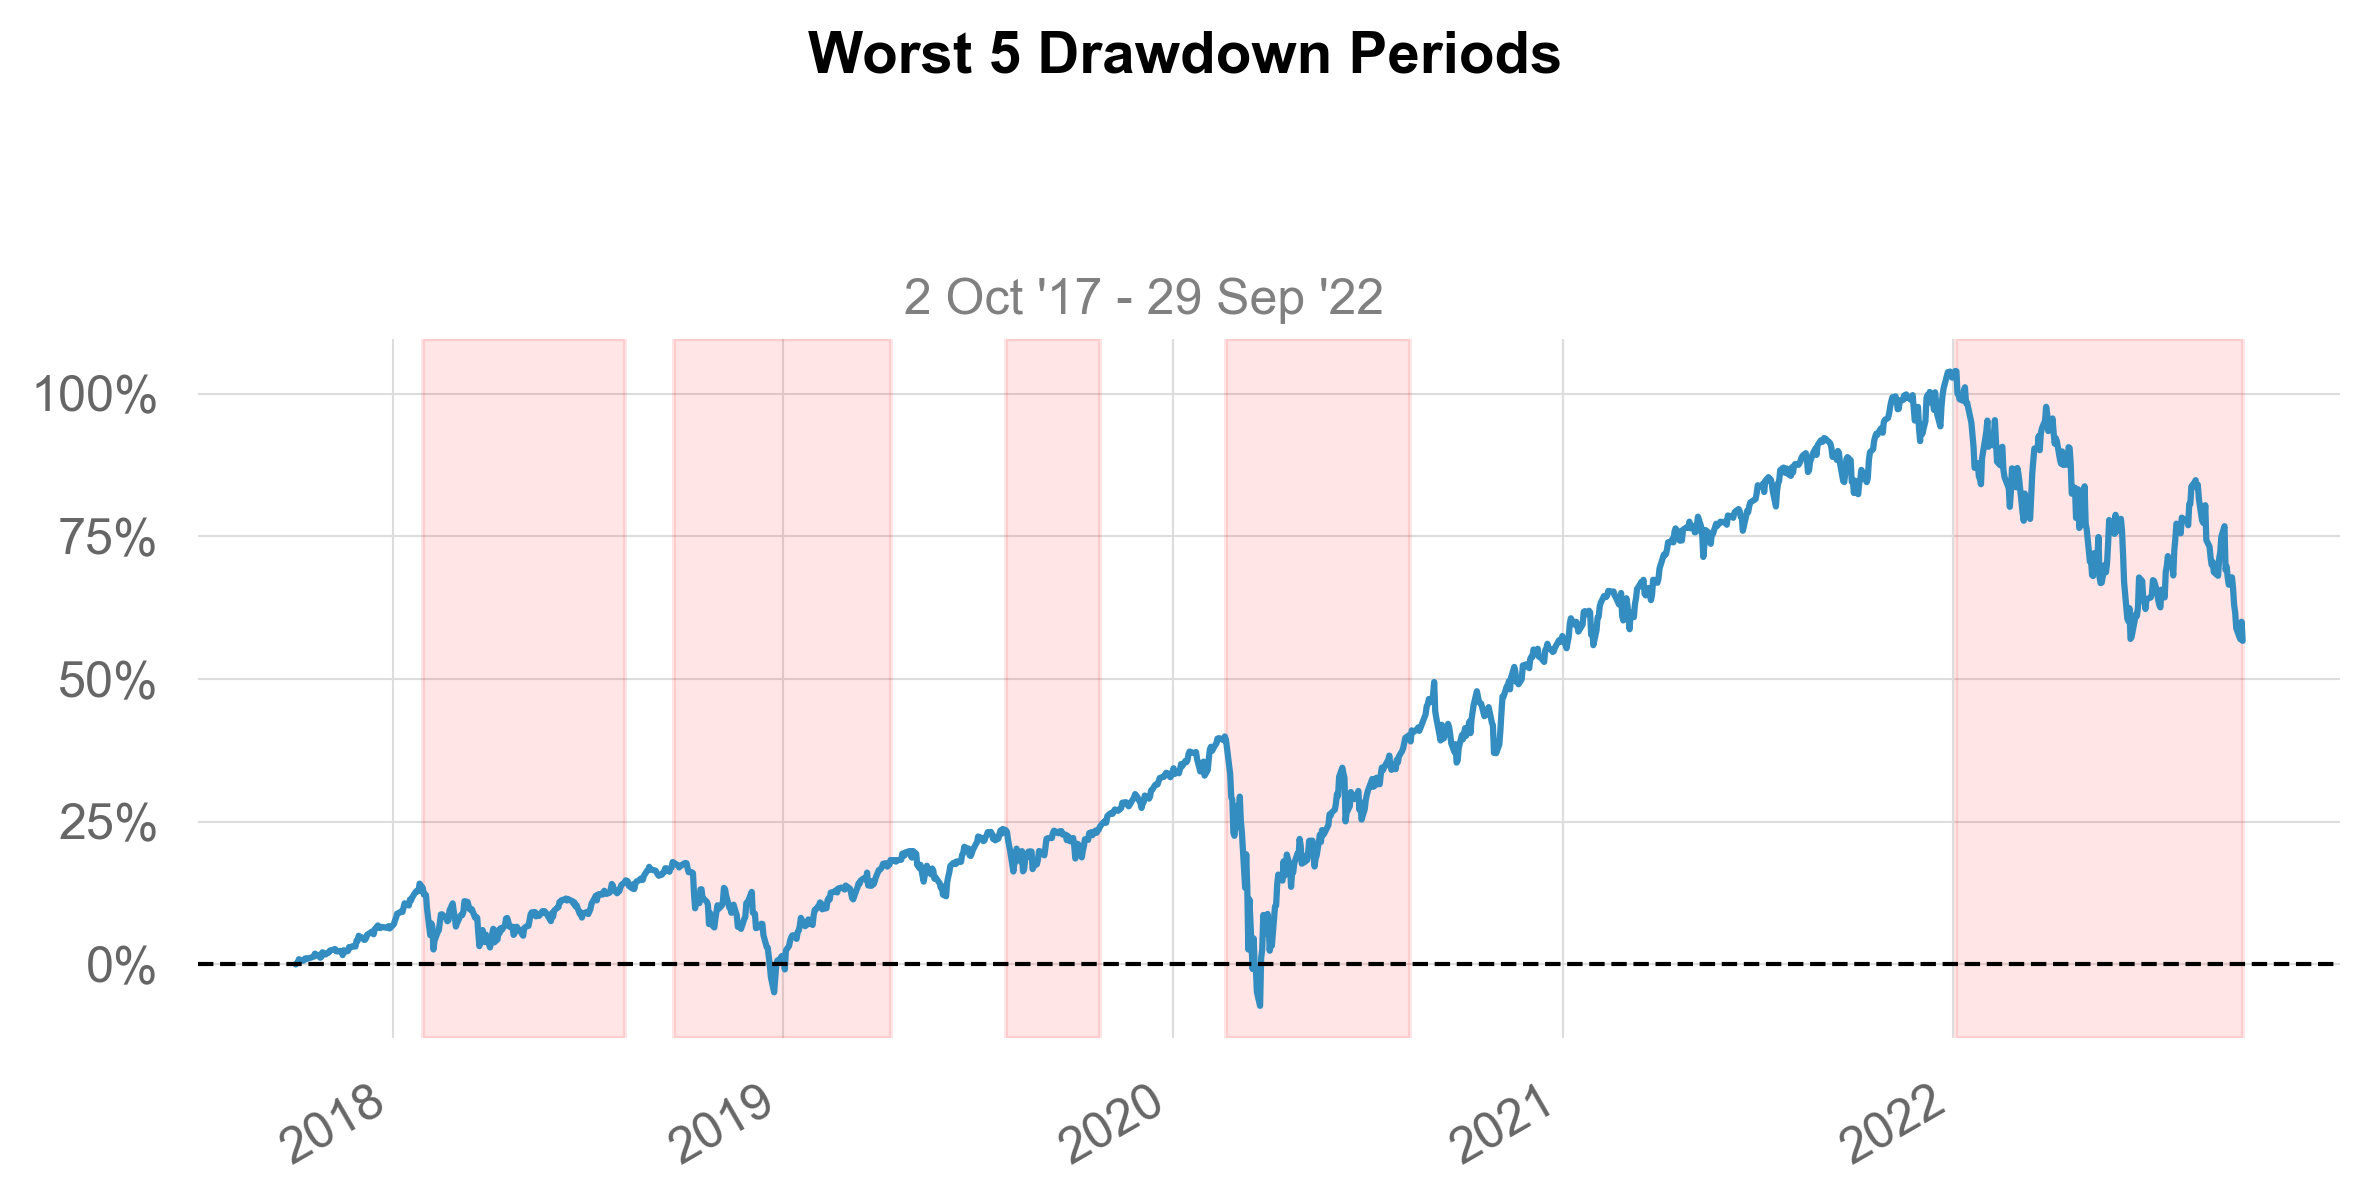

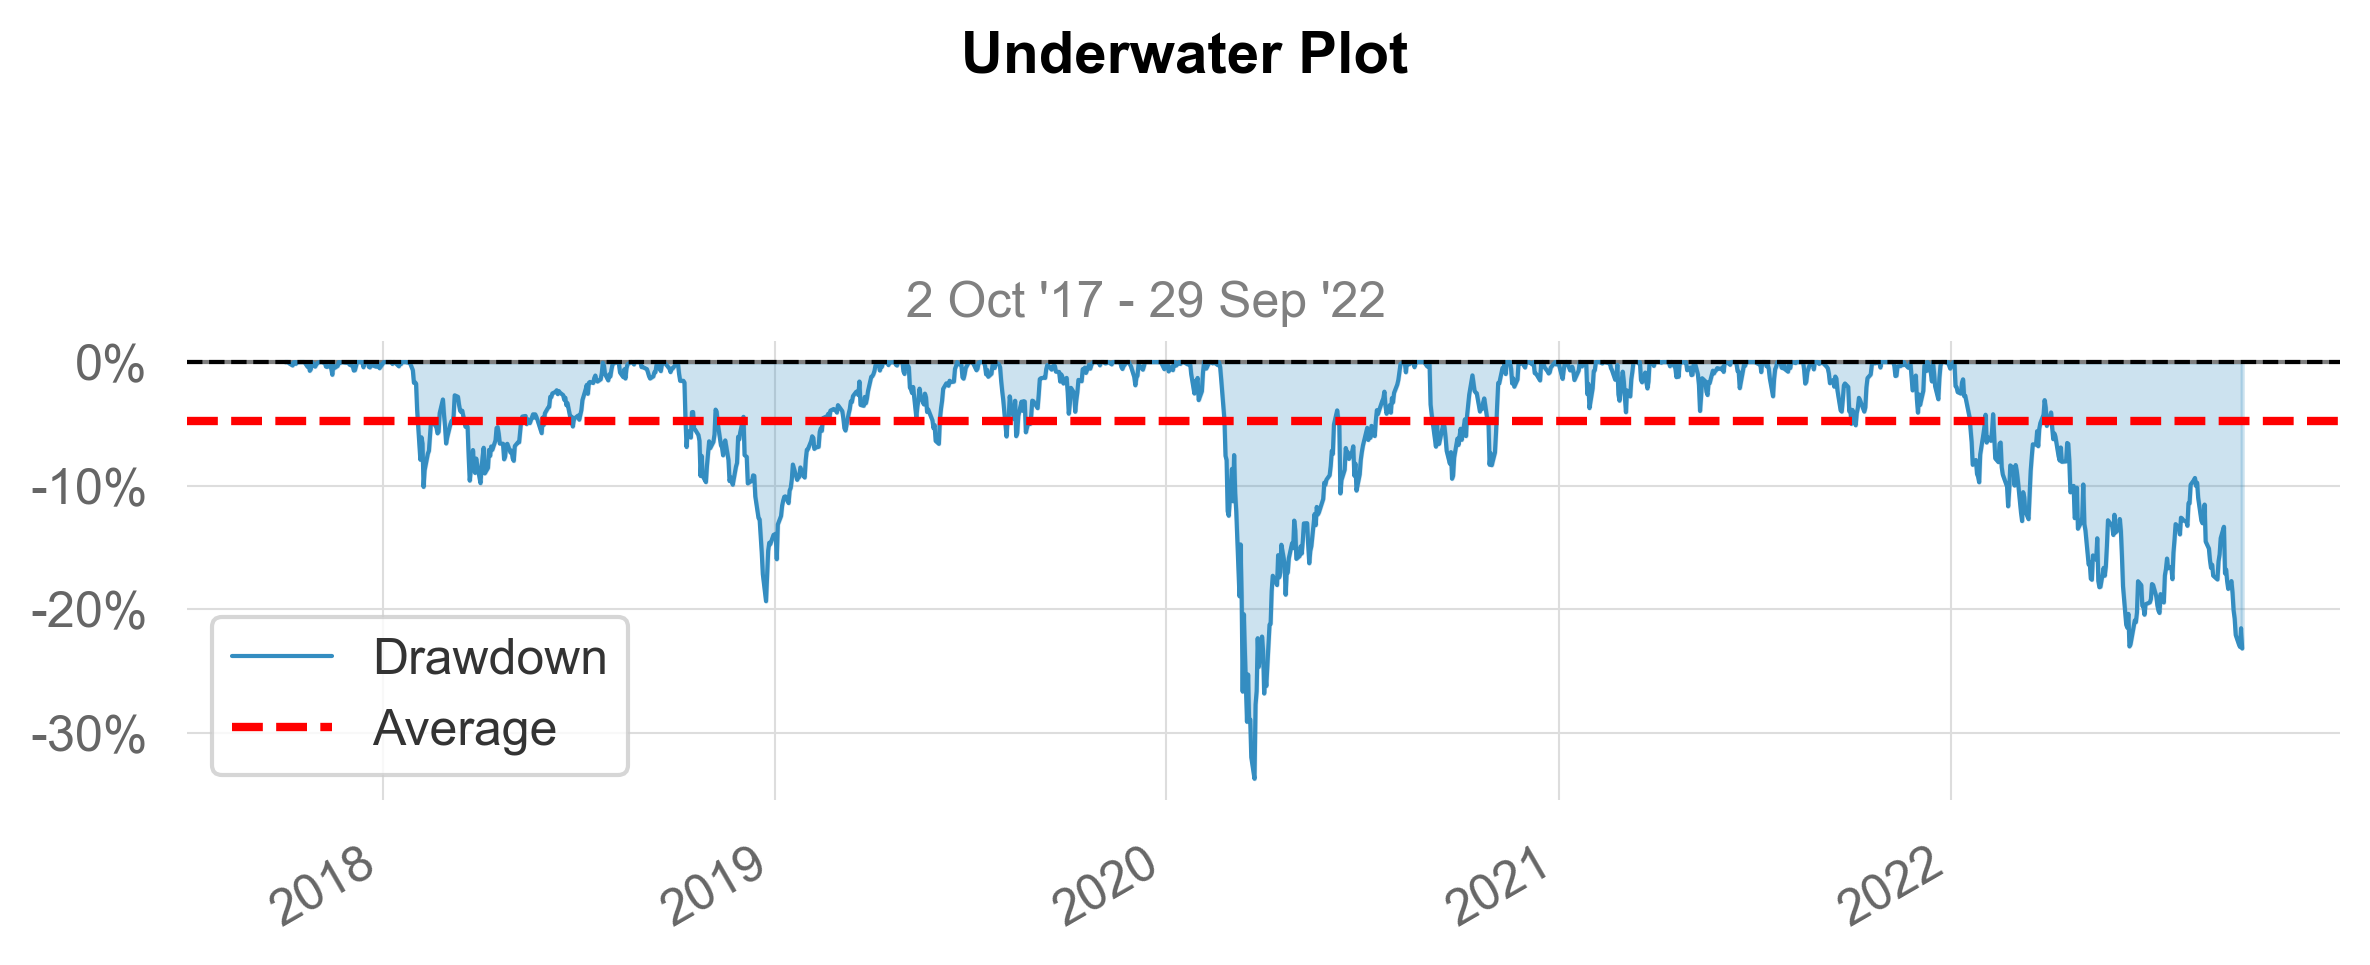

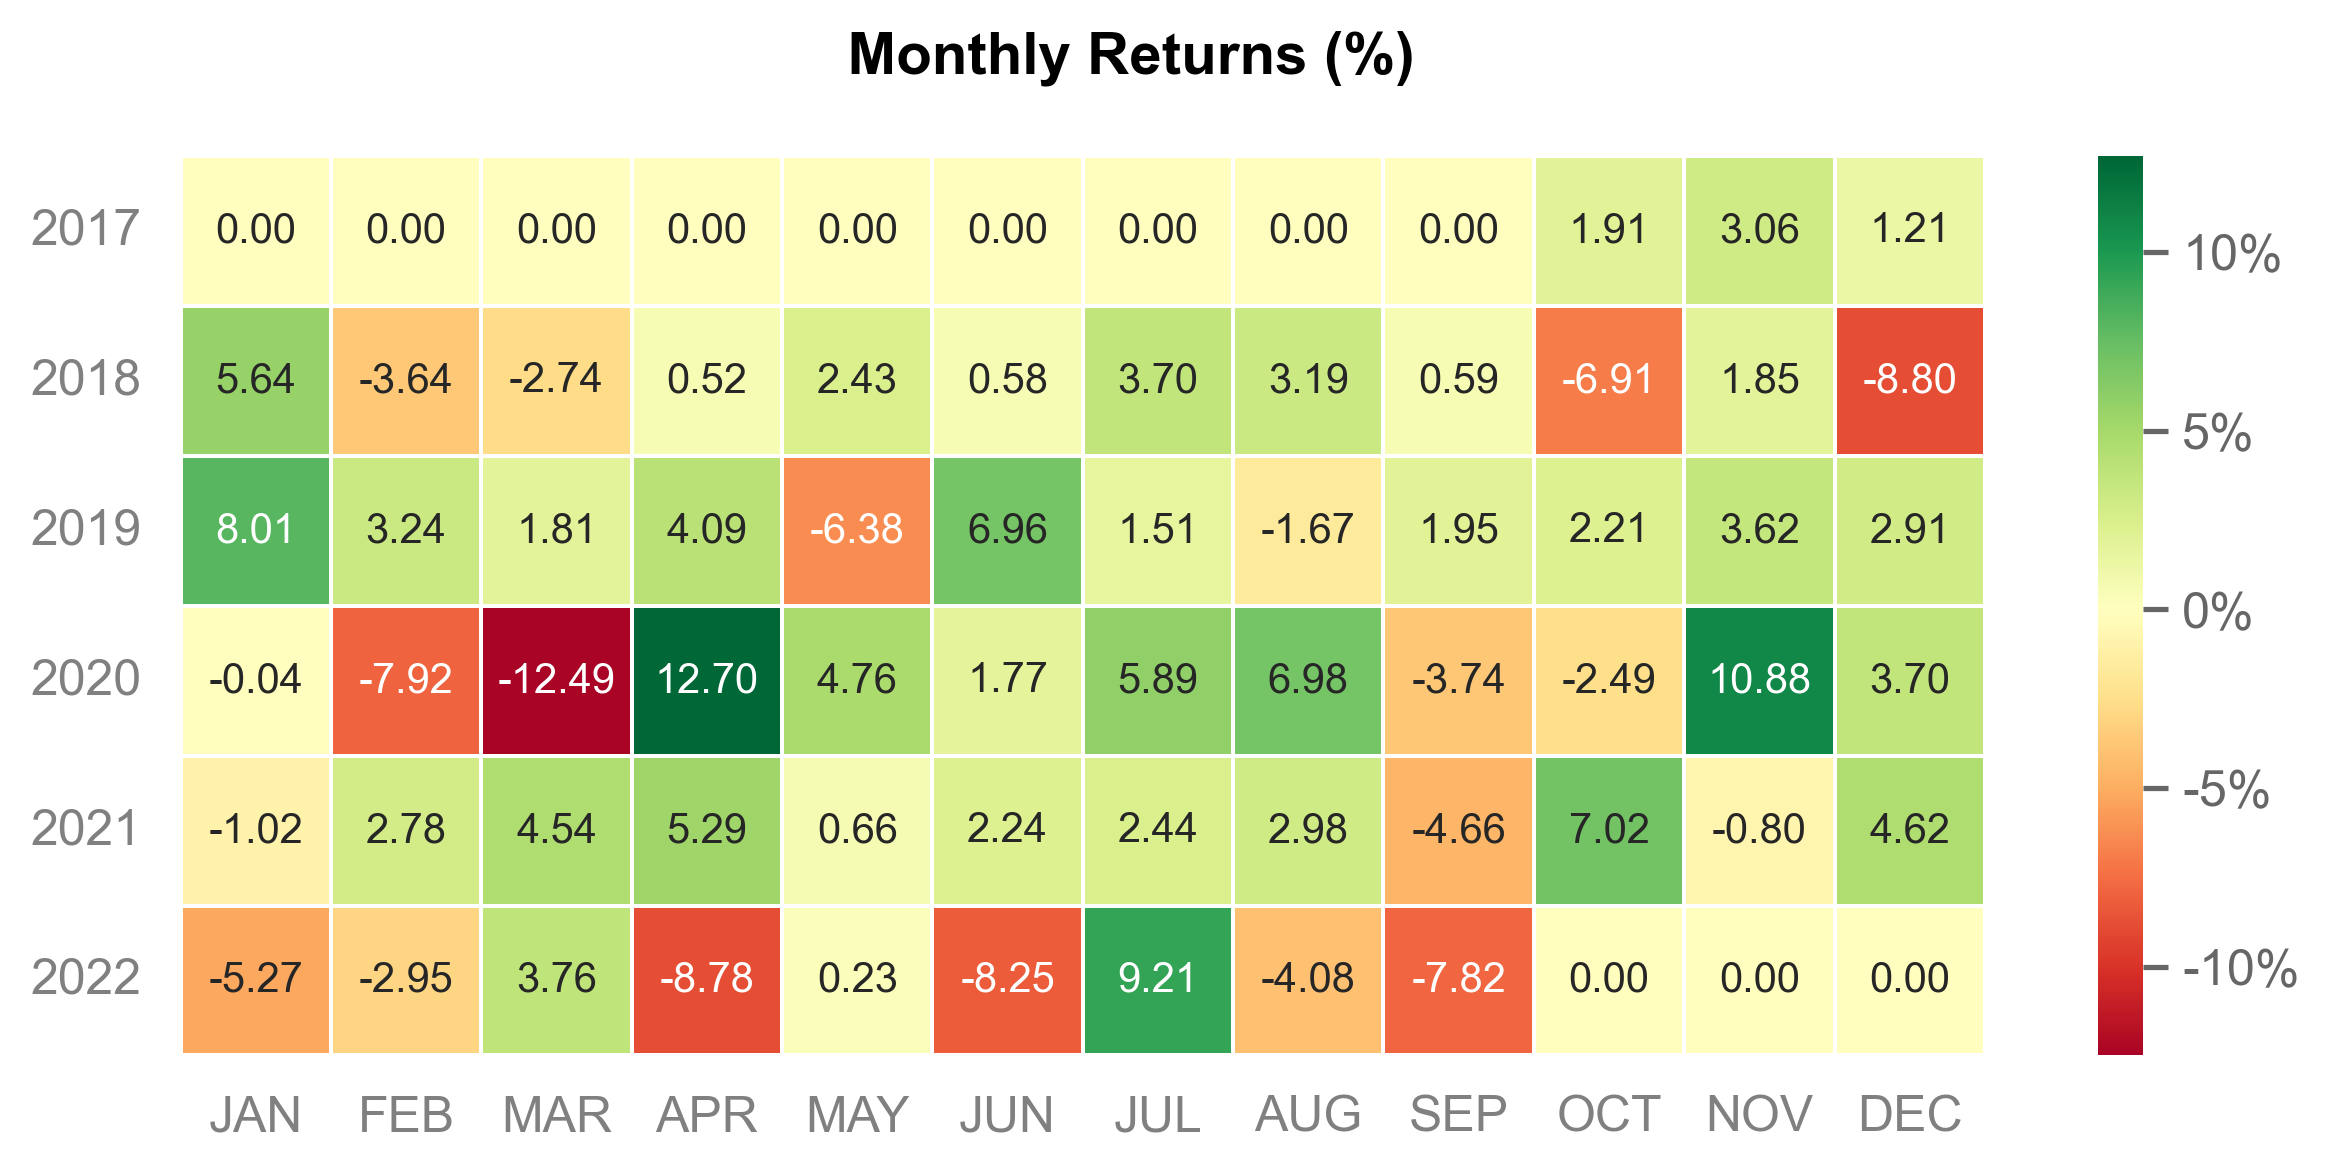

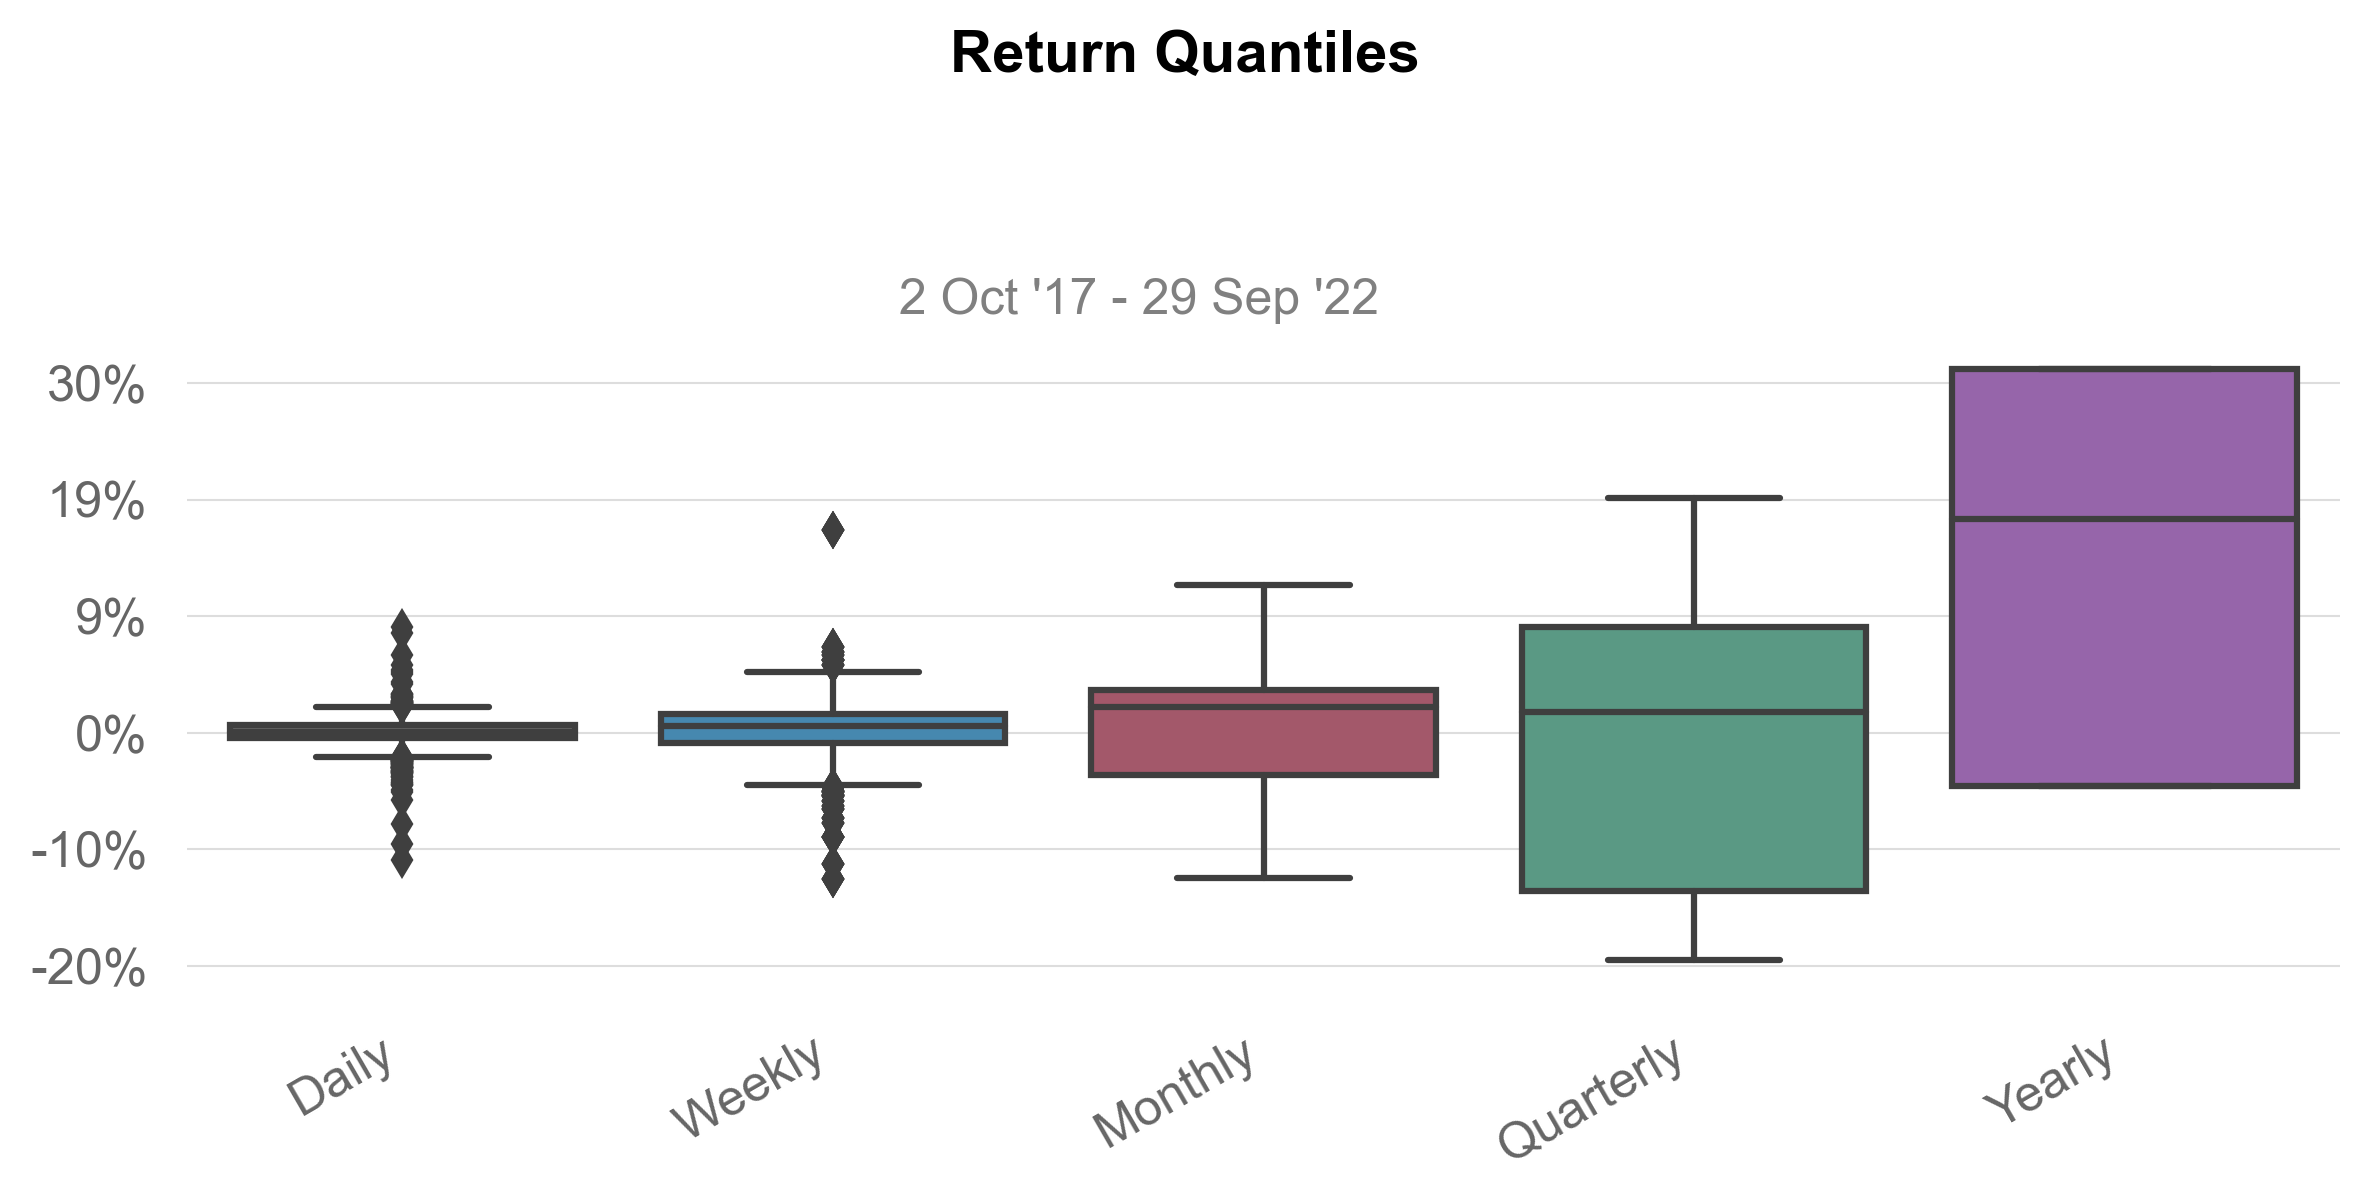

In [ ]:
#| hide
returns = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
full(returns, benchmark, display=False)

In [ ]:
#| export
def basic(returns, benchmark=None, rf=0., grayscale=False,
          figsize=(8, 5), display=True, compounded=True,
          periods_per_year=252, match_dates=False):

    # prepare timeseries
    returns = _utils.prepare_returns(returns)
    if benchmark is not None:
        benchmark = _utils.prepare_benchmark(benchmark, returns.index, rf)
        if match_dates is True:
            returns, benchmark = _match_dates(returns, benchmark)

    if _utils._in_notebook():
        iDisplay(iHTML('<h4>Performance Metrics</h4>'))
        metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='basic',
                compounded=compounded,
                periods_per_year=periods_per_year,
                prepare_returns=False)
        iDisplay(iHTML('<h4>Strategy Visualization</h4>'))
    else:
        print('[Performance Metrics]\n')
        metrics(returns=returns, benchmark=benchmark,
                rf=rf, display=display, mode='basic',
                compounded=compounded,
                periods_per_year=periods_per_year,
                prepare_returns=False)

        print('\n\n')
        print('[Strategy Visualization]\nvia Matplotlib')

    plots(returns=returns, benchmark=benchmark,
          grayscale=grayscale, figsize=figsize, mode='basic',
          periods_per_year=periods_per_year,
          prepare_returns=False)

In [ ]:
#| hide
returns = _utils.download_returns('SPY', '5y')
benchmark = _utils.download_returns('QQQ', '5y')
# basic(returns, benchmark, display=False)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()